# Imports

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd

# from matplotlib.colors import Lognorm
from scipy.integrate import simps
from time import time
import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [3]:
from ipywidgets import interact
import seaborn as sns
sns.set(palette='colorblind', style='whitegrid')
sns.set_style({'font.family': ['serif']})
from matplotlib.colors import LogNorm, SymLogNorm

In [4]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
RBF = kernels.RBF
WhiteKernel = kernels.WhiteKernel

In [5]:
sys.path.append('../cf_analysis/')
import tools

import glearn
from rscm import RSCM
# from cf_analysis import pcalearn
from sklearn.decomposition import PCA
from svdanalysis import SVDlearn
import synth, kde, pcalearn
from pcalearn import PCAYJ

# from cf_analysis import kde
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
KernelRegression = kde.KernelRegression

import yjtransform as yjt


# Setup

In [6]:

class GetObject(object):
    def __init__(self, *initial_data, **kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])           
            
    

In [7]:
data = pd.read_csv('../The_Tax_Burden_on_Tobacco__1970-2017.csv')
data = data[data['Year'] <=2005]
years = data['Year'].unique()
# Tf = years[years <=2005]
sales = data[data['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
costs = data[data['SubMeasureDesc'] == 'Average Cost per pack ']    

statesid = data['LocationAbbr'].unique()
statesales, statecosts = {}, {}
for ss in statesid:
    statesales[ss] = sales[sales['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
    statecosts[ss] = costs[costs['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']
taxstates = ['CA', 'MA', 'OR', 'FL', 'AZ']
controlstates = list(set(statesid) - set(sskip))


controls = np.array([statesales[ss] for ss in statesid if ss!= 'CA'])
# controls = np.array([statesales[ss] for ss in controlstates if ss!= 'CA'])
treated = statesales['CA']

X = np.array([statesales[ss] for ss in statesid ])

# ncd = 5
# # Xraw = np.array([statesales[i] for i in statesales.keys()])
# Xraw = np.array([statesales[i] for i in controlstates])
# Xrawmean = Xraw.mean(axis=0)
# Xraw -= Xrawmean
# pcad = PCA(ncd).fit(Xraw)
# X = pcad.inverse_transform(pcad.transform(Xraw))

N, T = X.shape[0], X.shape[1]
T0 = 18
itreated = 4
t = np.arange(T)
xplot = years.copy()

In [9]:
tools.approximate_rank(controls - controls.mean(axis=0), 0.99)

8

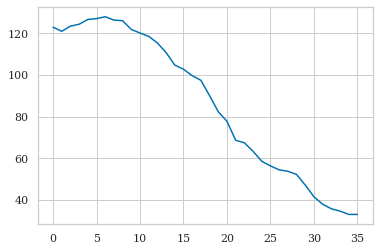

In [23]:
plt.plot(X[itreated])

In [24]:


# years = t           
# xplot = years.copy()            

# data = pd.read_csv('../basque.csv')
# years = data['year'].unique()
# T0 = np.where(years == 1970)[0][0]
# years = years[:2*T0]
# gdp = data['gdpcap'].values.reshape(18, -1)
# gdp = gdp[1:, :2*T0]
# treated = gdp[-2]
# rr = data['regionname'].unique()[-2]
# controls = np.append(gdp[:-2], gdp[-1:], axis=0)

# X = gdp.copy()
# N, T = X.shape[0], X.shape[1]
# t = np.arange(T)
# itreated = 15



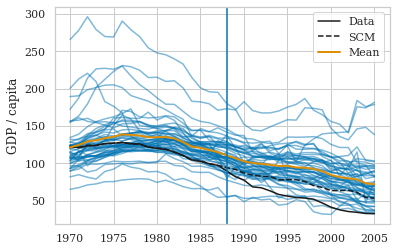

In [25]:
plt.plot(years, controls.T, 'C0', alpha=0.5)
plt.plot(years, treated, 'k', label='Data')
plt.plot(years, synth.fit(controls, treated, T0)[0],'k--', label='SCM')
plt.plot(years, controls.mean(axis=0), 'C1', lw=2, label='Mean')
# plt.plot(pcad.inverse_transform(pcad.transform((treated-Xrawmean).reshape(1, -1))).flatten()+Xrawmean)
# plt.plot(Xraw[4]+Xrawmean)
# plt.plot(X[4]+Xrawmean)
plt.ylabel('GDP / capita')
plt.axvline(years[T0])
plt.legend()
plt.show()



In [26]:
# T = 100
# ncd = 10
# t = np.arange(0, T)
# T0 = 60
# N = 50


# X = np.random.normal(10, 2, N*T).reshape(N, T)
# X = X + np.random.normal(0, N, N).reshape(-1, 1)
# X = X + np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1).reshape(-1, 1)*t/T
# X = X + np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)*t**2/T * np.exp(-2*t/T)
# # X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.pi/T* t* np.random.normal(size=N).reshape(-1, 1)) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(0)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(1)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(2)*np.pi/T* t) 

# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(3)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(4)*np.pi/T* t) 
# Xraw = X.copy()
# pcad = PCA(ncd).fit(Xraw)
# X = pcad.inverse_transform(pcad.transform(Xraw))

# itreated = np.random.randint(N)
# controls = np.concatenate([X[:itreated], X[itreated+1:]])
# treated = X[itreated]

# fig, ax = plt.subplots(1, 2, figsize = (8, 4))
# ax[0].plot(Xraw.T)
# ax[1].plot(controls.T, 'b', alpha=0.5)
# ax[1].plot(treated, 'r', alpha=1)
# plt.show()
# plt.plot(pcad.components_.T);
# plt.show()
# plt.plot(np.linalg.svd(Xraw)[1], 'o');
# plt.semilogy()
# plt.show()

# SCM

In [27]:

scmfits =  {}
for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    ##
    X1 = (xx - means)[:, :T0]
    X2 = (xx - means)[:, T0:]
    Y1 = (yy-means)[:T0]
    Y2 = (yy-means)[T0:]
    yp, wts = synth.fit(xx, yy, T0)
        
    scmfits[ss] = GetObject(controls=xx, treated=yy, pred=yp, wts=wts)
    
    
    

scmfitsres =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    ##
    ##
    mmx, mmy = xxc[:, :T0].mean(axis=1), yyc[:T0].mean()
    xx = xxc - mmx.reshape(-1, 1)
    yy = yyc - mmy
    
    yp, wts = synth.fit(xx, yy, T0)    
    yp += mmy
    
    scmfitsres[ss] = GetObject(controls=xxc, treated=yyc, pred=yp, wts=wts)    

# Fourier Anlaysis

[]

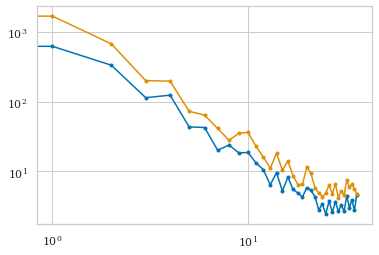

In [28]:
diff, difft = controls[:, :T0].mean(axis=1).reshape(-1, 1), treated[:T0].mean()
gl = glearn.GLearn(controls - diff, padl=T//2, padr=T//2, stdscale=False)
glpred, glerr, glcov = gl.fit(treated - difft, T0)
glpred += difft
plt.plot(gl.pkraw, marker='.')
plt.plot(gl.pkprior, marker='.')
plt.loglog()

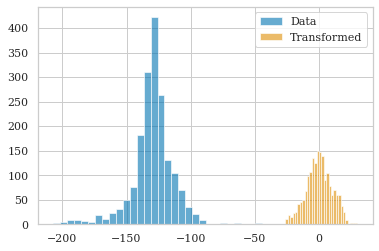

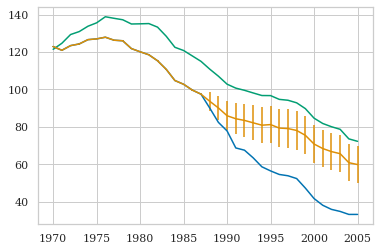

In [29]:

bins = 30 
normed = False
# plt.hist((controls - means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
plt.hist((gl.controls-controls.mean(axis=0)).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
plt.hist(gl.controlsg.flatten(), bins=bins, normed=normed, label='Transformed', alpha=0.6, color='C1')
plt.legend()
plt.show()
# plt.hist(gca.controls.flatten())
plt.plot(years, treated)
plt.errorbar(years, glpred, glerr)
plt.plot(years, controls.mean(axis=0))

In [30]:

glfits =  {}
for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    diff, difft = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
    ##
    ##
    gl = glearn.GLearn(xx-diff, padl=T, padr=T, stdscale=False)
    yp, err, cov = gl.fit(yy-difft, T0)
    yp += difft
    glfits[ss] = GetObject(controls=xx, treated=yy, pred=yp, err=err, cov=cov)
    
    


scmfits 23.5314364143329
scmfitsres 23.925249725482125
glfits 27.07123054661131


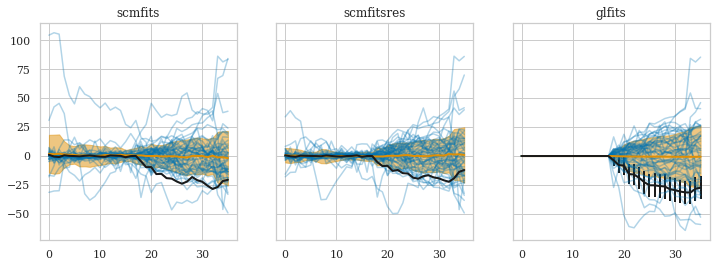

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = 'scmfits, scmfitsres, glfits'
titles = titles.split(', ')
for j, fits in enumerate([scmfits, scmfitsres, glfits]):
    tmp = []
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', lw=2)
    except: axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2) 
#     axis.set_ylim(-50, 50)

#     axis.set_ylim(-50, 50)

scmfits 23.5314364143329
scmfitsres 23.925249725482125
glfits 27.07123054661131


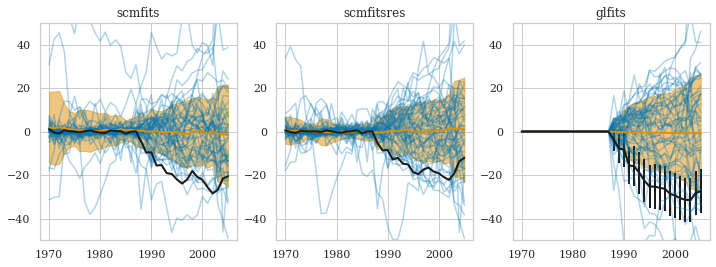

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
xplot = years.copy()

# titles = ['scmfits', 'scmfitsres',  'pca99', 'pcafits95', 'pcafits99reg', 'pcafitsyj99', 'pcafitsyj95', 'svdfits99']
titles = 'scmfits, scmfitsres, glfits'
titles = titles.split(', ')
for j, fits in enumerate([scmfits, scmfitsres, glfits]):
    tmp = []
    axis = ax.flatten()[j]
#     for ii in range(X.shape[0]): 
#         tmp.append(fits[ii].treated - fits[ii].pred)
#         axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    for ii, fi in enumerate(fits): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', lw=2)
    except: axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
    axis.set_ylim(-50, 50)

# PCA

7


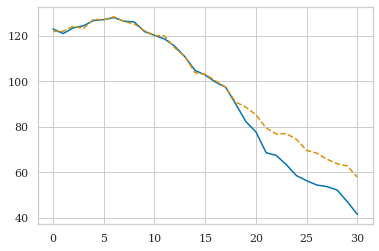

In [115]:
xx = controls.copy()
means = xx.mean(axis=0)*1
yy = treated.copy()
xplot = np.arange(yy.size)
xx -= means
yy -= means
mmx = xx[: , :T0].mean(axis=1)*0
mmy = yy[:T0].mean()*0
xx -= mmx.reshape(-1, 1)
yy -= mmy
##
i = 0 
ncomp = tools.approximate_rank(xx, t=0.99)
print(ncomp)

# ncomp = tools.approximate_rank(xx - means, t=0.999)
ncomp = 10
# ncomp = 4
# print(ncomp)
pclT0 = pcalearn.PCAlearn(xx[:, :T0], ncomp, stdscale=False, normalization='center', whiten=True)
pcaT0 = pclT0.pca

pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center', whiten=True)
pca = pcl.pca
errpca = pca.get_covariance().diagonal()**0.5

##
ypca, pp = pcl.fit(yy.flatten(), T0, regwt=None, verbose=True)
ypca += means
ypca += mmy
plt.plot(xplot, treated, label='data')
plt.plot(xplot, ypca , '--')
# plt.plot(xplot, yy + means, label='data')
# plt.plot(xplot, means, ':')
# plt.plot(xplot, ypcar, ":", lw=3, alpha=0.5)
# plt.plot(xplot, ypcar2, ':', lw=3, alpha=0.5)


In [116]:
ncomp = tools.approximate_rank(xx, t=0.95)
print(ncomp)
pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization=None, whiten=False)
pca = pcl.pca
xx2 = pcl.unnormalize(pca.inverse_transform(pca.transform(pcl.normalize(xx))))
# plt.plot(xx.T);
# plt.plot(xx2.T, '--');
# pca.explained_variance_
# np.linalg.eigvals(np.cov(xx.T)).real.sum() , np.linalg.eigvals(np.cov(xx.T)).real[ncomp:].sum() 
# ( np.linalg.svd(xx,full_matrices=False)[1]**2 ).sum() / (xx.shape[0]-1)
pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1), ((xx - xx2)**2).sum()/xx.shape[0] 


2


(1201.5585497906081, 1177.527378794793)

In [117]:
ncomp = tools.approximate_rank(xx[:, :T0], t=0.95)
print(ncomp)
pcl = pcalearn.PCAlearn(xx[:, :T0], ncomp, stdscale=False, normalization=None, whiten=False)
pca = pcl.pca
xx2 = pcl.unnormalize(pca.inverse_transform(pca.transform(pcl.normalize(xx[:, :T0]))))
# plt.plot(xx.T);
# plt.plot(xx2.T, '--');
# pca.explained_variance_
# np.linalg.eigvals(np.cov(xx.T)).real.sum() , np.linalg.eigvals(np.cov(xx.T)).real[ncomp:].sum() 
# ( np.linalg.svd(xx,full_matrices=False)[1]**2 ).sum() / (xx.shape[0]-1)
pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1), ((xx[:, :T0] - xx2)**2)[:T0].sum()/T0

2


(442.26084923440425, 536.8861878827684)

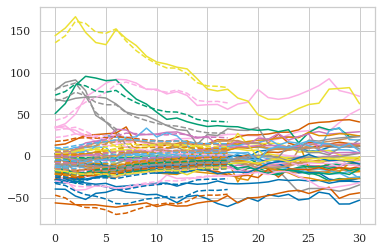

In [118]:
plt.plot(xx.T);
plt.plot(xx2.T, '--');


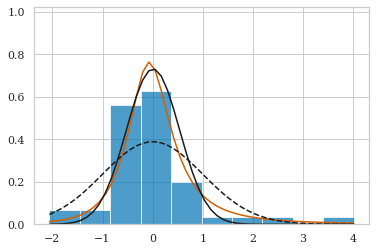

In [119]:
nbins=10
pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center', whiten=True)
pca = pcl.pca
xxt = pca.transform(pcl.normalize(xx))
tt = xxt[:, 0].copy()
plt.hist(tt.flatten(), alpha=0.7, bins=nbins, density=True)
ptt = yjt.get_transform(tt)
# plt.plot(ttx, yjt.invtransform(ttx, ptt))
ttx = np.linspace(tt.min(), tt.max())
qq = yjt.getpdf(ttx, ptt)
plt.plot(ttx, qq, 'r')

y_, x_, _ = plt.hist(yjt.transform(tt,  ptt).flatten(), alpha=0.0, bins=nbins, density=True)
x_ = (x_[1:] + x_[:-1])/2.
pp = tools.fitgausspdf(yjt.transform(tt,  ptt).flatten(), normalized=True, verbose=0)    
# plt.plot(x_, y_.max()*tools.logpdf_gauss(x_, *pp, rety=True), 'k')
# plt.plot(x_, y_.max()*tools.logpdf_gauss(x_, 0., 1., rety=True), 'k--')
plt.plot(ttx, y_.max()*tools.logpdf_gauss(ttx, *pp, rety=True), 'k')
plt.plot(ttx, y_.max()*tools.logpdf_gauss(ttx, 0., 1., rety=True), 'k--')


IndexError: index 2 is out of bounds for axis 1 with size 2

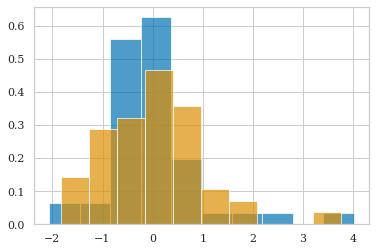

In [120]:
nbins=10
pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center', whiten=True)
pca = pcl.pca
xxt = pca.transform(pcl.normalize(xx))
tt = xxt[:, 0].copy()
plt.hist(tt.flatten(), alpha=0.7, bins=nbins, density=True)
tt = xxt[:, 1].copy()
plt.hist(tt.flatten(), alpha=0.7, bins=nbins, density=True)
tt = xxt[:, 2].copy()
y_, _, _ = plt.hist(tt.flatten(), alpha=0.7, bins=nbins, density=True)

ttx = np.linspace(tt.min(), tt.max())

# y_, x_, _ = plt.hist(yjt.transform(tt,  ptt).flatten(), alpha=0.0, bins=nbins, density=True)
# x_ = (x_[1:] + x_[:-1])/2.
# pp = tools.fitgausspdf(yjt.transform(tt,  ptt).flatten(), normalized=True, verbose=0)    
# # plt.plot(x_, y_.max()*tools.logpdf_gauss(x_, *pp, rety=True), 'k')
# # plt.plot(x_, y_.max()*tools.logpdf_gauss(x_, 0., 1., rety=True), 'k--')
# plt.plot(ttx, y_.max()*tools.logpdf_gauss(ttx, *pp, rety=True), 'k')
plt.plot(ttx, tools.logpdf_gauss(ttx, 0., 1., rety=True), 'k--')


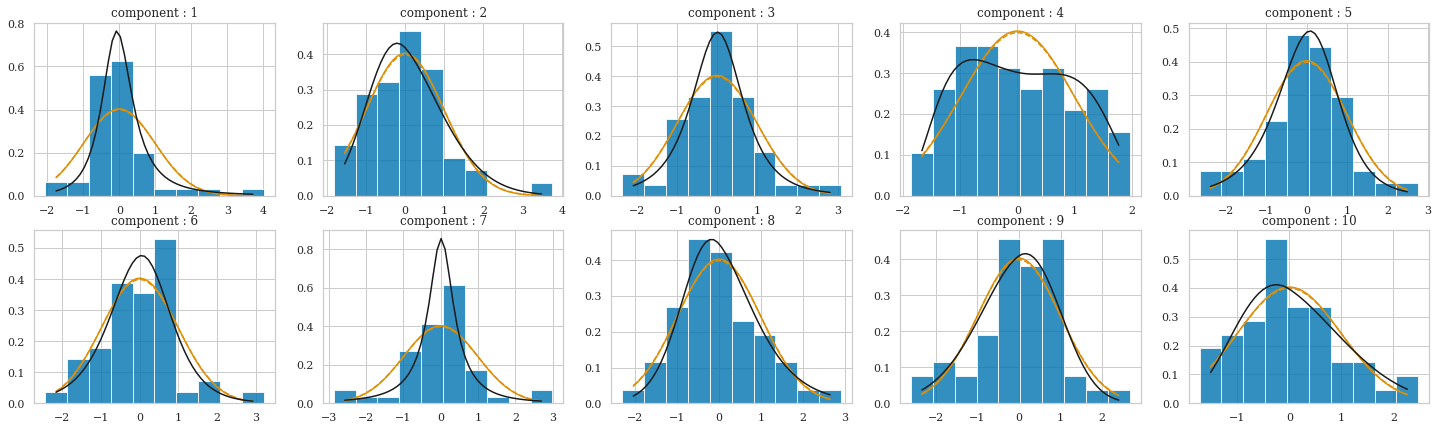

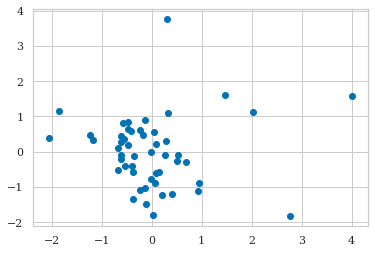

In [125]:
nbins = 10 
normed = True

ncomp = 10
xx = controls.copy()
pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center', whiten=True)
pca = pcl.pca
xxt = pca.transform(pcl.normalize(xx))

fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*5, 7))

ax = axar.flatten()
for ia in range(ncomp):
    if ia >= ax.size: break
    if ia > ncomp: break    
    y_, x_, _ = ax[ia].hist(xxt.T[ia], bins=nbins, density=normed, alpha=0.8)
    x_ = (x_[1:] + x_[:-1])/2.

    xplot = np.linspace(x_.min(), x_.max())
    ppg = tools.fitgausspdf(xxt.T[ia], normalized=True, verbose=0)    
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, 0, 1, rety=True, normalized=True), 'C1--')
    ax[ia].set_title("component : %d"%(ia+1))
    pyj = yjt.get_transform(xxt.T[ia])
    qq = yjt.getpdf(xplot, pyj)
    ax[ia].plot(xplot, qq, 'k')
    
    
plt.show()
plt.scatter(xxt[:, 0], xxt[:, 1])
plt.show()

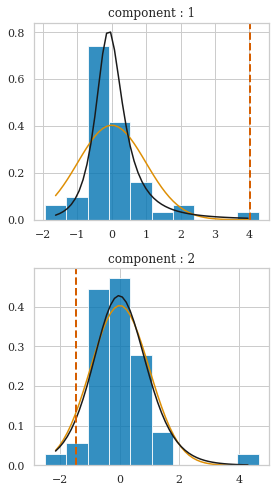

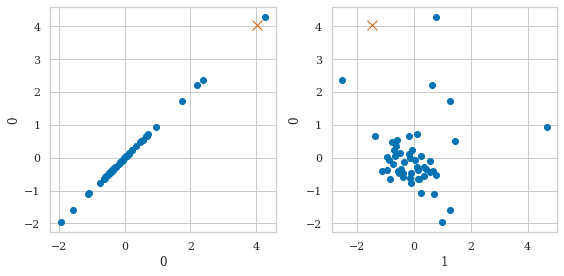

In [121]:
xxT0 = pcaT0.transform(pclT0.normalize(xx[:, :T0]))
ppT0 = pcaT0.transform(pclT0.normalize(treated[:T0]).reshape(1, -1))[0]

# fig, ax = plt.subplots(1, ncomp, figsize= (ncomp*4, 4))

# ppT0 = pcaT0.transform(treated[:T0].reshape(np.newaxis, 1))

fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*4, 7))

ax = axar.flatten()
for ia in range(ncomp):
    if ia >= ax.size: break
    if ia > ncomp: break    
    y_, x_, _ = ax[ia].hist(xxT0.T[ia], bins=nbins, density=normed, alpha=0.8)
    x_ = (x_[1:] + x_[:-1])/2.

    xplot = np.linspace(x_.min(), x_.max())
    ppg = tools.fitgausspdf(xxT0.T[ia], normalized=True, verbose=0)    
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    
    pyj = yjt.get_transform(xxT0.T[ia])
    qq = yjt.getpdf(xplot, pyj)
    ax[ia].plot(xplot, qq, 'k')
    
    ax[ia].axvline(ppT0[ia], color='r', lw=2, ls="--")
    ax[ia].set_title("component : %d"%(ia+1))

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, ncomp, figsize= (ncomp*4, 4))
ic = 0 
# for ia in range(ncomp):
#     for ib in range(ia+1, ncomp):
#         ax[ic].scatter(xxT0[:, ia], xxT0[:, ib])
#         ax[ic].plot(ppT0[ia], ppT0[ib], 'rx', markersize=10, lw=2)
#         ax[ic].set_xlabel(ia)
#         ax[ic].set_ylabel(ib)
#         ic += 1
for ia in range(ncomp):
    ax[ic].scatter(xxT0[:, ia], xxT0[:, 0])
    ax[ic].plot(ppT0[ia], ppT0[0], 'rx', markersize=10, lw=2)
    ax[ic].set_xlabel(ia)
    ax[ic].set_ylabel(0)
    ic += 1

plt.tight_layout()
plt.show()

In [26]:
pcafits95 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    if not ii: print(ncpca)
    if ncpca  == 1: ncpca += 1
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
    ypca2, err, pp2 = pcl.fitanalytic(yy.flatten(), T0,  regwt=None, verbose=False, noise=noise)
    pcafits95[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, err=err)



    
pcafits99 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    if not ii: print(ncpca)
    if ncpca  == 1: ncpca += 1
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
    ypca2, err, pp2 = pcl.fitanalytic(yy.flatten(), T0,  regwt=None, verbose=False, noise=noise)
    pcafits99[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, err=err)

    
    
    
# pcafits95res = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.95)
    
#     ##
#     pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     ##
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=None, verbose=False)
#     pcafits95[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)

    

3
8


<ErrorbarContainer object of 3 artists>

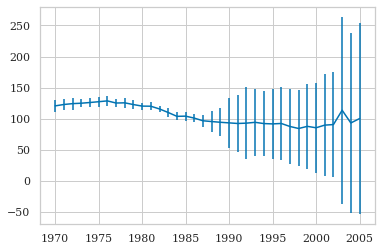

In [27]:
plt.errorbar(years, pcafits99[4].pred, pcafits99[4].err)

1
2
5


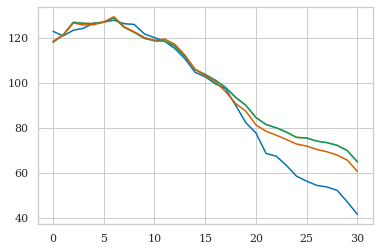

In [329]:

svdfits99 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]]).copy()
    yy = X[ii].copy()
    means = xx.mean(axis=0)
    ncsvd = tools.approximate_rank(xx, t=0.99)
    if not ii : print(ncsvd)
    if ncsvd == 1 : ncsvd +=1 
    ##
    svl = SVDlearn(xx, stdscale=False, normalization=None)
    yp, pp = svl.fit(yy.flatten(), T0, ncsvd, verbose=False)
    svdfits99[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp, nc=ncsvd)



svdfits995 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]]).copy()
    yy = X[ii].copy()
    means = xx.mean(axis=0)
    ncsvd = tools.approximate_rank(xx, t=0.995)
    if not ii : print(ncsvd)
    if ncsvd == 1 : ncsvd +=1 
    ##
    svl = SVDlearn(xx, stdscale=False, normalization=None)
    yp, pp = svl.fit(yy.flatten(), T0, ncsvd, verbose=False)
    svdfits995[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp, nc=ncsvd)
    

svdfits999 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]]).copy()
    yy = X[ii].copy()
    means = xx.mean(axis=0)
    ncsvd = tools.approximate_rank(xx, t=0.999)
    if not ii : print(ncsvd)
    if ncsvd == 1 : ncsvd +=1 
    ##
    svl = SVDlearn(xx, stdscale=False, normalization=None)
    yp, pp = svl.fit(yy.flatten(), T0, ncsvd, verbose=False)
    svdfits999[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp, nc=ncsvd)

plt.plot(svdfits99[itreated].treated)
plt.plot(svdfits99[itreated].pred)
plt.plot(svdfits995[itreated].pred)
plt.plot(svdfits999[itreated].pred)
# plt.plot(pcapreds[itreated].pred)
# plt.plot(pcapreds[itreated].pred)
# plt.plot(pcapreds[itreated].pred)
    

In [330]:
# pcafits95reg = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.95)
#     ##
#     pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
#     ##
# #     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-5, 0, 100), verbose=0, method='bfgs', dT=3)
# #     pcafits95reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)
#     ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 0, 100), verbose=0, dT=3, retreg=True)
#     pcafits95reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)
    
# pcafits99reg = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.99)
#     ##
#     pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
#     ##
# #     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-5, 0, 100), verbose=0, method='bfgs', dT=3)
# #     pcafits99reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)
#     ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 0, 100), verbose=0, dT=3, retreg=True)
#     pcafits99reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)



In [331]:
pcafits95reg = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    ##
    ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2, 100), verbose=0, dT=3, retreg=True)
    pcafits95reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)
    
pcafits99reg = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    ##
    ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2, 100), verbose=0, dT=3, retreg=True)
    pcafits99reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)

    
    

pcafits95regnoise = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    pca = pcl.pca
#     noise = (xx - pcl.unnormalize(pca.inverse_transform(pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-5, 0, 100), verbose=0, method='bfgs', dT=3)
#     pcafits95reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)
    ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2, 100), verbose=0, dT=3, retreg=True, noise=noise)
    pcafits95regnoise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)
    
pcafits99regnoise = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    pca = pcl.pca
#     noise = (xx - pcl.unnormalize(pca.inverse_transform(pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-5, 0, 100), verbose=0, method='bfgs', dT=3)
#     pcafits99reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)
    ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2, 100), verbose=0, dT=3, retreg=True, noise=noise)
    pcafits99regnoise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)


# pcafits95regnoisepca = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.95)
#     ##
#     pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
#     pca = pcl.pca
#     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
#     ##
#     ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 0, 100), verbose=0, dT=3, retreg=True, noise=noise)
#     pcafits95regnoisepca[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)
    
# pcafits99regnoisepca = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.99)
#     ##
#     pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
#     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
#     ##
#     ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 0, 100), verbose=0, dT=3, retreg=True, noise=noise)
#     pcafits99regnoisepca[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)

    
   

In [332]:
# pcafits95regnm = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.95)
#     ##
#     pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
#     ##
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-5, 0, 100), verbose=0, method='nelder-mead', dT=3)
#     pcafits95regnm[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)

# pcafits99regnm = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.99)
#     ##
#     pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
#     ##
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-5, 0, 100), verbose=0, method='nelder-mead', dT=3)
#     pcafits99regnm[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)



# PCAYJ

19
21.815376848515662
min rms is at reg = 3.511e-01


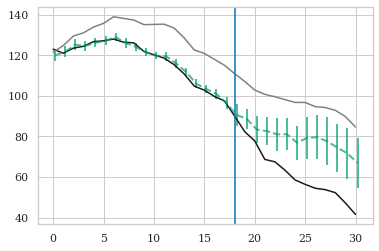

In [45]:
# pcayj = PCAYJ(controls, 5, whiten=False)
# # ty, tp = pcayj.fit(treated, T0, verbose=2, method='nelder-mead')
# ty, tp = pcayj.fit(treated, T0, verbose=2, method='bfgs')
# # plt.plot(means, 'gray')
# plt.plot(treated)
# plt.plot(ty)
# plt.plot(ypca, '--')


xplot = t.copy()
xx = controls.copy()
means = xx.mean(axis=0)
yy = treated.copy()

ncomp = tools.approximate_rank(controls-means , t=0.999)
# ncomp = 10
print(ncomp)

##
i = 0 
pcl = pcalearn.PCAlearn(controls, ncomp, stdscale=False, normalization='center')
pca = pcl.pca
errpca = pca.get_covariance().diagonal()**0.5

ty0, tp = pcl.fit(treated, T0, verbose=2, method='bfgs', regwt=None)
ty, tyerr, tp = pcl.fitanalytic(treated, T0, verbose=2, regwt=0, noise=noise)
# noise = (controls - pca.inverse_transform(pca.transform(controls - means)) - means)[:, :T0].std()**2
# print(noise)
# # noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
# noise = controls[:, :T0].std()
noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
# noise = 1
print(noise)
tyreg, tyerrreg, tpreg, tregwt = pcl.fitanalytic(treated, T0, regwt=np.logspace(-7, 2, 100), noise=noise, verbose=2, retreg=True)

pcayj = PCAYJ(controls, ncomp, whiten=False, normalization='center')
tyyj, tpyj = pcayj.fit(treated, T0, verbose=0, method='bfgs', noise=noise)
sigma = [tools.fitgausspdf(i)[1] for i in pcayj.pca.transform(pcayj.normalize(controls)).T]
_, tyerryj, _  = pcayj.fitanalytic(treated, T0, sigma=sigma, noise=noise)

plt.plot(xplot, treated, 'k')
plt.plot(xplot, means, 'gray')
# plt.plot(xplot, ty0, 'C0')
# plt.errorbar(xplot, tyreg, tyerrreg, color='C1', ls="--", lw=2, alpha=0.7)
# plt.plot(xplot, tyyj, 'C2')
plt.errorbar(xplot+0.2, tyyj, tyerryj, color='C2', ls="--", lw=2, alpha=0.7)
# plt.errorbar(xplot+0.4, ty, tyerr,  color= 'C3')
plt.axvline(t[T0])

In [46]:
# pcafitsyj95 = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.95)
#     ##
#     pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     ##
#     method = 'bfgs'
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
#     _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma)
#     pcafitsyj95[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, err=err)

# print('pcafitsyj95 done')

# pcafitsyj99 = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.99)
#     ##
#     pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     ##
#     method = 'bfgs'
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
#     _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma)    
#     pcafitsyj99[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, err=err)

# print('pcafitsyj99 done')


# pcafitsyj95noise = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.95)
#     ##
#     pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     pca = pcl.pca
#     sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
# #     noise = xx[:, :T0].std()**2
#     noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
#     ##
#     method = 'bfgs'
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method, noise=noise)
#     _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)    
#     pcafitsyj95noise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, noise=noise, err=err)

# print('pcafitsyj95noise done')

# pcafitsyj99noise = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.99)
#     ##
#     pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     pca = pcl.pca
#     sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
# #     noise = xx[:, :T0].std()**2
#     ##
#     method = 'bfgs'
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
#     _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)    
#     pcafitsyj99noise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, noise=noise, err=err)

# print('pcafitsyj99noise done')


    
pcafitsyj999noise = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.999)
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
#     noise = xx[:, :T0].std()**2
    ##
    method = 'bfgs'
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)    
    pcafitsyj999noise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, noise=noise, err=err)

print('pcafitsyj99noise done')


    

# pcafitsyj95noisepca = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.95)
#     ##
#     pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
# #     noise = xx[:, :T0].std()**2
#     ##
#     method = 'bfgs'
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method, noise=noise)
#     _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)    
#     pcafitsyj95noisepca[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, noise=noise, err=err)

# print('pcafitsyj95noisepc done')

# pcafitsyj99noisepca = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.99)
#     ##
#     pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
# #     noise = xx[:, :T0].std()**2
#     ##
#     method = 'bfgs'
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
#     _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)    
#     pcafitsyj99noisepca[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, noise=noise, err=err)

# print('pcafitsyj99noisepc done')

    

KeyboardInterrupt: 

scmfits 15.265298048631163
scmfitsres 14.013002396366728
pcafits99 29.542384356481126
pcafits95 24.62936204777077
pcafits95reg 19.075747022631877
pcafits99reg 25.283315659937852
pcafitsyj95 24.56762640966921
pcafitsyj99 28.17405068060933
svdfits99 18.64960363830767
pcafits95regnoise 18.010612455506884
pcafits99regnoise 19.213019689784673
pcafitsyj95noise 17.982822284052034
pcafitsyj99noise 28.17405068060933


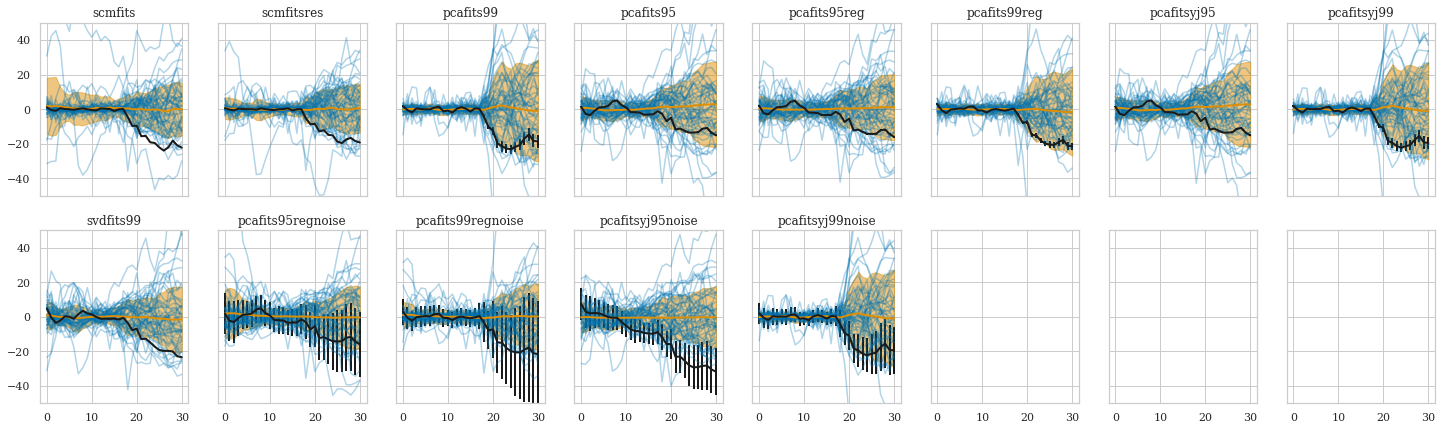

In [333]:
fig, ax = plt.subplots(2, 8, figsize=(25, 7), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = ['scmfits', 'scmfitsres',  'pca99', 'pcafits95', 'pcafits99reg', 'pcafitsyj99', 'pcafitsyj95', 'svdfits99']
titles = 'scmfits, scmfitsres, pcafits99, pcafits95, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99'
titles = titles.split(', ')
for j, fits in enumerate([scmfits, scmfitsres, pcafits99, pcafits95, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99]):
    tmp = []
    axis = ax[0].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', lw=2)
    except: axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
    axis.set_ylim(-50, 50)

titles = ['scmfits', 'scmfitsres',  'pca99', 'pcafits95', 'pcafits99reg', 'pcafitsyj99', 'pcafitsyj95', 'svdfits99']
titles = 'svdfits99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise'
titles = titles.split(', ')
for j, fits in enumerate([svdfits99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise]):
    tmp = []
    axis = ax[1].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', lw=2)
    except: axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
    axis.set_ylim(-50, 50)

### Vary components

In [50]:

xx = controls.copy()
means = xx.mean(axis=0)*1
yy = treated.copy()
xplot = np.arange(yy.size)
xx -= means
yy -= means
# mmx = xx[: , :T0].mean(axis=1)*0
# mmy = yy[:T0].mean()*0
# xx -= mmx.reshape(-1, 1)
# yy -= mmy
#
pcapreds = {}
pcapredsyj = {}
pcapredsreg = {}
pcapredsyjnoise = {}
pcapredsregnoise = {}
svdpreds = {}

i = 0 
for ncomp in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ypca, err, pp = pcl.fitanalytic(yy.flatten(), T0, regwt=None, verbose=True, noise=noise)
    ypca += means
    pcapreds[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err)
    
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    ypca, err, pp, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2), verbose=True, retreg=True)
    ypca += means
    pcapredsreg[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err, regwt=regwt)

    #
    pcl = PCAYJ(xx, ncomp, stdscale=False, normalization='center', whiten=False)
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    ypcayj, ppyj = pcl.fit(yy.flatten(), T0, method='bfgs')
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma)
    pcapredsyj[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypcayj+means, pcl=pcl, fitp=ppyj, nc=ncomp, err=err)
    
#     noise = xx[:, :T0].std()
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ypca, err, pp,regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2), verbose=True, noise=noise, retreg=True)
    ypca += means
    pcapredsregnoise[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err, regwt=regwt, noise=noise)

    #
    pcl = PCAYJ(xx, ncomp, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    ypcayj, ppyj = pcl.fit(yy.flatten(), T0, method='bfgs', noise=noise, verbose=2)
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise, verbose=2)
    pcapredsyjnoise[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypcayj+means, pcl=pcl, fitp=ppyj, nc=ncomp, err=err, noise=noise)

    ##
    svl = SVDlearn(controls.copy(), stdscale=False, normalization=None)
    yp, pp = svl.fit(treated.copy(), T0, ncomp, verbose=False)
    svdpreds[ncomp] = GetObject(controls=controls.copy(), treated=treated.copy(), svl=svl, pred=yp, fitp=pp, nc=ncomp)


min rms is at reg = 1.000e-05
min rms is at reg = 1.000e-05
[-56.07711821]
      fun: 5.644395962656719
 hess_inv: array([[1490.09683483]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 5
     njev: 12
   status: 0
  success: True
        x: array([-32.6207286])
0.32350325466857505 -5.320892707988144
min rms is at reg = 5.179e+01
min rms is at reg = 3.728e-02
[-86.37011439  58.76920107]
      fun: 10.949854204837731
 hess_inv: array([[1099.53557433, -545.54758471],
       [-545.54758471,  520.62813493]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 92
      nit: 17
     njev: 23
   status: 0
  success: True
        x: array([-52.46610147,  14.50853034])
0.5464904986535457 -10.403363706184185
min rms is at reg = 3.728e+01
min rms is at reg = 3.728e-02
[-99.53549993  78.60076854 -13.05330702]
      fun: 14.658754911357729
 hess_inv: array([[1004.64881672, -209.05737034,  115.58303527],
      

30.01362341781923

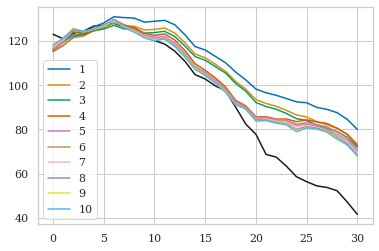

In [49]:
plt.plot(xplot, treated, 'k')
for nn in range(1, 11):
#     plt.errorbar(xplot, pcapredsyj[nn].pred, pcapredsyj[nn].err, label=nn)
#     plt.errorbar(xplot, pcapredsyjnoise[nn].pred, pcapredsyjnoise[nn].err, label=nn)
    plt.errorbar(xplot, pcapredsyjnoise[nn].pred, label=nn)
#     plt.errorbar(xplot, pcapredsreg[nn].pred, pcapredsreg[nn].err, label=nn)
#     plt.errorbar(xplot, pcapredsregnoise[nn].pred, pcapredsregnoise[nn].err, label=nn)
#     plt.plot(pcapredsreg[nn].pred, label=nn)
plt.legend()

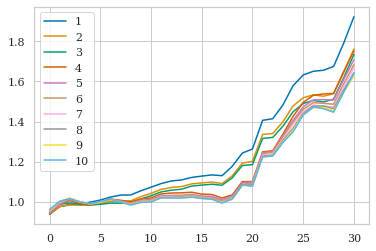

In [53]:
# plt.plot(xplot, treated, 'k')
for nn in range(1, 11):
    plt.errorbar(xplot, pcapredsyjnoise[nn].pred/treated, label=nn)
plt.legend()


# KDE

0.0014933932161242517
2 2


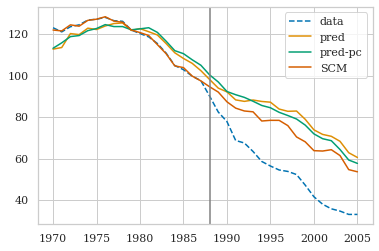

In [81]:
def get_ykde(gg, X1, X2, Y1, gamma=np.logspace(-3, 0, 1000), caty1=True):
    kde = KernelRegression(gg, gamma=gamma)
    kde.fit(X1, X2)
    if len(Y1.shape) <=1: Y1 =  Y1.reshape(1,-1)
    ykde, wts = kde.predict(Y1, retK=True)
    ykde0 = kde.predict(Y1, X1, retK=False)
    ykde = ykde.flatten()
    ykde0 = ykde0.flatten()
    if caty1 == 1: ykde = np.concatenate([Y1.flatten(), ykde])
    elif caty1 == 2: ykde = np.concatenate([ykde0, ykde]) 
    return ykde, kde, wts
 

ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*0
stds = xxc.std(axis=0)*0 + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

##
X1 = xx[:, :T0]
X2 = xx[:, T0:]
Y1 = yy[:T0]
Y2 = yy[T0:]

#
yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
print(kde.gamma)
yp *= stds
yp += means


plt.plot(years, yyc, '--', label='data')
plt.plot(years, yp, label='pred')
# plt.plot(years, means, 'k--', label='means')


nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
if nc1 <=1 : nc1 +=1 
if nc2 <=1 : nc2 +=1 
print(nc1, nc2)
# nc1, nc2 = 3, 3 
p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
XX1, XX2 = p1.transform(X1), p2.transform(X2)
YY1 = p1.transform(Y1.reshape(1,-1))
ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
y1, y2 = ykdep[:nc1], ykdep[nc1:]
yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
yp *= stds
yp += means
plt.plot(years, yp, label='pred-pc')

ypscm, wts = synth.fit(xx, yy, T0)
plt.plot(years, ypscm*stds + means, label='SCM')
plt.axvline(years[T0], color='gray')
plt.legend()

0.0014933932161242517
0.0017999285067824766


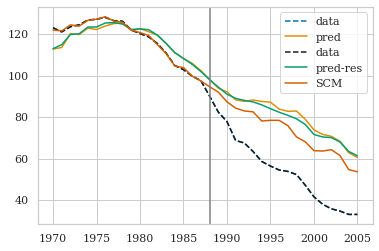

In [82]:

ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]

##
means = xxc.mean(axis=0)*0
stds = xxc.std(axis=0)*0 + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

X1 = xx[:, :T0]
X2 = xx[:, T0:]
Y1 = yy[:T0]
Y2 = yy[T0:]

#
yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
print(kde.gamma)
yp *= stds
yp += means


plt.plot(years, yyc, '--', label='data')
plt.plot(years, yp, label='pred')


xx = xxc - xxc[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
yy = yyc - yyc[:T0].mean(axis=0)#(xxc - means)/stds

##
X1 = xx[:, :T0]
X2 = xx[:, T0:]
Y1 = yy[:T0]
Y2 = yy[T0:]

#
yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
print(kde.gamma)
# yp *= stds
yp +=  yyc[:T0].mean(axis=0)#(xxc - means)/stds


plt.plot(years, yyc, 'k--', label='data')
plt.plot(years, yp, label='pred-res')
# plt.plot(years, means, 'k--', label='means')


# nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
# if nc1 <=1 : nc1 +=1 
# if nc2 <=1 : nc2 +=1 
# print(nc1, nc2)
# # nc1, nc2 = 3, 3 
# p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
# XX1, XX2 = p1.transform(X1), p2.transform(X2)
# YY1 = p1.transform(Y1.reshape(1,-1))
# ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
# y1, y2 = ykdep[:nc1], ykdep[nc1:]
# yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
# yp *= stds
# yp += means
# plt.plot(years, yp, label='pred-pc')

ypscm, wts = synth.fit(controls, treated, T0)
plt.plot(years, ypscm, label='SCM')
plt.axvline(years[T0], color='gray')
plt.legend()

In [83]:
# kdefitsvanilla =  {}
# for ii, ss in enumerate(np.arange(N)):
#     xxc = np.concatenate([X[:ii], X[ii+1:]])
#     yyc = X[ii]
#     means = xxc.mean(axis=0)*0
#     stds = xxc.std(axis=0)*0 + 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds
#     ##
#     X1 = xx[:, :T0]
#     X2 = xx[:, T0:]
#     Y1 = yy[:T0]
#     Y2 = yy[T0:]
#     yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
#     yp *= stds
#     yp += means
#     kdefitsvanilla[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

# kdefitsmeans =  {}
# for ii, ss in enumerate(np.arange(N)):
#     xxc = np.concatenate([X[:ii], X[ii+1:]])
#     yyc = X[ii]
#     means = xxc.mean(axis=0)
#     stds = xxc.std(axis=0)*0 + 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds
#     ##
#     X1 = xx[:, :T0]
#     X2 = xx[:, T0:]
#     Y1 = yy[:T0]
#     Y2 = yy[T0:]
#     yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
#     yp *= stds
#     yp += means
#     kdefitsmeans[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

kdefits =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefits[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)


kdefitspca99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    nc = tools.approximate_rank(xx, 0.99)
    pca = PCA(nc).fit(xx)
    xx, yy = pca.inverse_transform(pca.transform(xx)), pca.inverse_transform(pca.transform(yy.reshape(1, -1)))
    yy = yy.flatten()
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefitspca99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, pca=pca, nc=nc)

print('kdefitspca99 done')

kdefitspcawts99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp *= stds
    yp += means
       
    kdefitspcawts99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)

    
print('kdefitspcawts99 done')

    
kdefitspcawts995 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
#     nc1, nc2 = 3, 3 # tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    nc1, nc2 = tools.approximate_rank(X1, 0.995), tools.approximate_rank(X2, 0.995)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp *= stds
    yp += means
        
    kdefitspcawts995[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)
    
print('kdefitspcawts995 done')

## KDE FITS RESIDUAL

kdefitsres =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
    yp +=  mmy
    yp *= stds
    yp += means
    kdefitsres[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

print('kdefitsres done')


kdefitsrespca99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    nc = tools.approximate_rank(xx, 0.99)
    pca = PCA(nc).fit(xx)
    xx, yy = pca.inverse_transform(pca.transform(xx)), pca.inverse_transform(pca.transform(yy.reshape(1, -1)))
    yy = yy.flatten()

    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
    yp +=  mmy
    yp *= stds
    yp += means
    kdefitsrespca99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

print('kdefitsrespca99 done')

kdefitsrespcawts99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp +=  mmy
    yp *= stds
    yp += means
        
    kdefitsrespcawts99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)
    
        

kdefitspca99 done
kdefitspcawts99 done
kdefitspcawts995 done
kdefitsres done
kdefitsrespca99 done


scmfits 23.5314364143329
scmfitsres 23.925249725482125
kdefits 27.869336496755317
kdefitspca99 28.069277252808263
kdefitspcawts99 27.735529021554644
kdefitsres 26.43310204458089
kdefitsrespca99 28.47106319756175
kdefitsrespcawts99 24.967592283243828


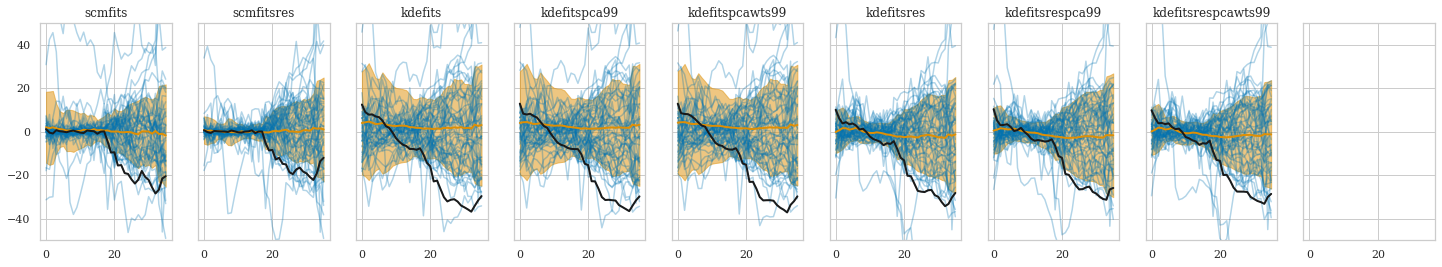

In [84]:
fig, ax = plt.subplots(1, 9, figsize=(25, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = ['scmfits', 'scmfitsres',  'kdefits', 'kdefitspca99', 'kdefitspcawts99', 
          'kdefitsres', 'kdefitsrespca99', 'kdefitsrespcawts99']
for j, fits in enumerate([scmfits, scmfitsres, kdefits, kdefitspca99, kdefitspcawts99,
                          kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
    tmp = []
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
    axis.set_ylim(-50,50)

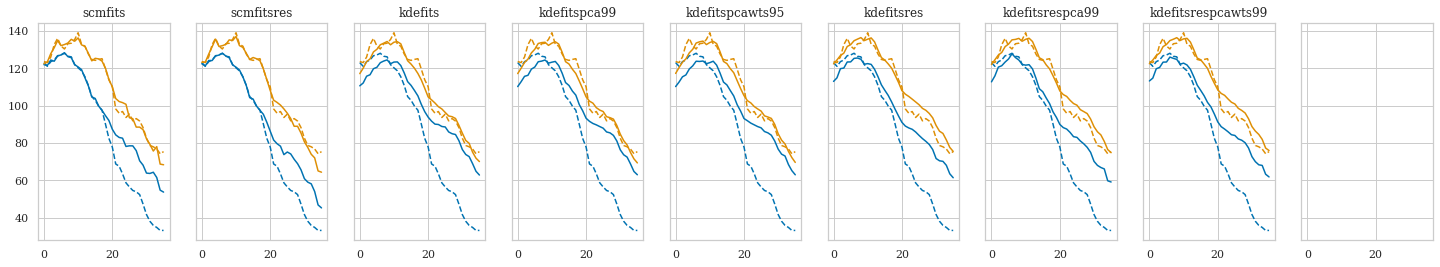

In [85]:
fig, ax = plt.subplots(1, 9, figsize=(25, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

iis = [4, 9]
titles = ['scmfits', 'scmfitsres',  'kdefits', 'kdefitspca99', 
          'kdefitspcawts95', 'kdefitsres', 'kdefitsrespca99', 'kdefitsrespcawts99']
# for j, fits in enumerate([scmfits, scmfitsres, kdefitsvanilla, kdefits, kdefitspca99,
#                           kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
for j, fits in enumerate([scmfits, scmfitsres,  kdefits, kdefitspca99,
                          kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
    axis = ax.flatten()[j]
    for i, ii in enumerate(iis): 
        axis.plot(fits[ii].pred, 'C%d'%i)
        axis.plot(fits[ii].treated, 'C%d--'%i)
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)

# GP

RBF(length_scale=0.957)


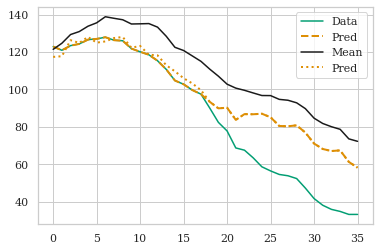

In [37]:
ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*1
stds = xxc.std(axis=0)*1# + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

xxp = xx.copy()
gp = GPR(kernels.RBF(0.1), n_restarts_optimizer=100, alpha=0.01).fit(xxp[:, :T0], xxp[:, T0:])
print(gp.kernel_)
ypred = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
yp = np.append(yyc[:T0], ypred*stds[T0:] + means[T0:])
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
ysample = ysample.T*stds[T0:]
err = np.append(np.zeros(T0), ysample.std(axis=0))

plt.plot(yyc, 'C2-', label='Data')
plt.plot(yp, 'C1--', label='Pred',lw=2)
# plt.plot(xxc.T, alpha=0.2, color='b')
plt.plot(means, color='k', label='Mean')

gpalpha = np.dot(np.linalg.inv(np.dot(gp.L_, gp.L_.T)), gp.y_train_)
gpkwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
wts = np.dot(gpkwts, np.linalg.inv(np.dot(gp.L_, gp.L_.T)))
pre = np.squeeze(np.dot(wts, gp.X_train_))
yp = np.append(pre, ypred)
yp *= stds
yp += means
plt.plot(yp, 'C1:', label='Pred',lw=2)
plt.legend()

13
0.9965562138478633
1.0
[0.33559288 0.22192675 0.43618956 0.64915802 0.72957528 0.4237626
 0.71862063 0.2951852  0.63072515 0.22686623 0.54757737 0.54579869
 0.44426412 1.30809868 0.36036899 0.75173336 0.82170119 0.60742339
 0.58258334 0.19340886 0.54841164 0.43867598 0.49923483 0.40560671
 0.29908866 0.6029467  0.49530688 0.40483749 0.59122676 0.42896451
 0.4530487  0.40467438 0.72867552 0.55450386 0.11103199 0.36748674
 0.78290992 0.36442753 0.7983021  0.47006606 0.49953737 0.34503522
 0.39813284 0.72560434 0.97971993 0.58472825 0.74715518 0.81551833
 0.32582501 0.91432025] 9.902388401519831
Matern(length_scale=11.2, nu=1.5)
RBF(length_scale=[27, 7.42, 54.7, 5.48, 5.27, 54.7, 3.94, 54.7, 17.4, 54.7, 54.7, 54.7, 26.2, 54.7, 54.7, 54.7, 54.7, 6.66])


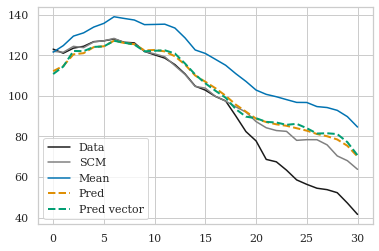

In [130]:
ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*1
stds = xxc.std(axis=0)*0 + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds
mmx, mmy = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
xx -= mmx
yy -= mmy


plt.plot(treated, 'k-', label='Data')
# plt.plot(
titles = ['scmfits', 'scmfitsres',  'pca99', 'pcafits95', 'pcafits99reg', 'pcafitsyj99', 'pcafitsyj95', 'svdfits99']
titles = 'svdfits99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise'
titles = titles.split(', ')
for j, fits in enumerate([svdfits99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise]):
    tmp = []
    axis = ax[1].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', lw=2)
    except: axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
    axis.set_ylim(-50, 50), 'k--', label='Truth')
# plt.plot(xxc.T, alpha=0.2, color='b')
plt.plot(synth.fit(controls, treated, T0)[0], color='gray', label='SCM')
plt.plot(means, color='C0', label='Mean')

# ncomp = tools.approximate_rank(controls - controls.mean(axis=0), 0.95)
ncomp = tools.approximate_rank(xx, 0.99)
print(ncomp)
pclpre = PCA(ncomp).fit(xx[:, :T0])
xxpre = pclpre.inverse_transform(pclpre.transform(xx[:, :T0]))
yypre = pclpre.inverse_transform(pclpre.transform(yy[:T0].reshape(1, -1))).flatten()
print((pclpre.explained_variance_ratio_).sum())
pclpost = PCA(ncomp).fit(xx[:, T0:])
xxpost = pclpost.inverse_transform(pclpost.transform(xx[:, T0:]))
yypost = pclpost.inverse_transform(pclpost.transform(yy[T0:].reshape(1, -1))).flatten()
print((pclpost.explained_variance_ratio_).sum())


alpha = (xx[:, :T0] - xxpre).std(axis=1)
print(alpha, xxpre.std())
dist = np.mean([np.median(((i - xxpre)**2).sum(axis=1)**0.5)  for i in xxpre])
# gp = GPR(kernels.RBF(xxpre.std(), [xxpre.std()/100., xxpre.std()*100.]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
# gp = GPR(kernels.Matern(xxpre.std()), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
# gp = GPR(kernels.RationalQuadratic(xxpre.std()), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
gp = GPR(kernels.Matern(dist, length_scale_bounds=[dist/10., dist*10.]), alpha=alpha, n_restarts_optimizer=100).fit(xxpre, xxpost)
print(gp.kernel_)
ypred = np.squeeze(gp.predict(yypre.reshape(1, -1)))
ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
yp = np.append(yyc[:T0], ypred*stds[T0:] + means[T0:])
yp += mmy
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
ysample = ysample.T*stds[T0:]
err = np.append(np.zeros(T0), ysample.std(axis=0))

gpalpha = np.dot(np.linalg.inv(np.dot(gp.L_, gp.L_.T)), gp.y_train_)
gpkwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
wts = np.dot(gpkwts, np.linalg.inv(np.dot(gp.L_, gp.L_.T)))
pre = np.squeeze(np.dot(wts, gp.X_train_))
yp = np.append(pre, ypred)
yp += mmy
yp *= stds
yp += means

plt.plot(yp, 'C1--', label='Pred',lw=2)


# ###########
alpha = (xx[:, :T0] - xxpre).std(axis=1)
dist = np.mean([(((i - xxpre)**2)**0.5).mean(axis=0)  for i in xxpre], axis=0)
gp = GPR(kernels.RBF(dist, [dist.min()/4., dist.max()*4.]), alpha=alpha, n_restarts_optimizer=100).fit(xxpre, xxpost)
# gp = GPR(kernels.RationalQuadratic(xxpre.std(axis=0)), n_restarts_optimizer=100).fit(xxpre, xxpost)
print(gp.kernel_)
ypred = np.squeeze(gp.predict(yypre.reshape(1, -1)))
ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
yp = np.append(yyc[:T0], ypred*stds[T0:] + means[T0:])
yp += mmy
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
ysample = ysample.T*stds[T0:]
err = np.append(np.zeros(T0), ysample.std(axis=0))

gpalpha = np.dot(np.linalg.inv(np.dot(gp.L_, gp.L_.T)), gp.y_train_)
gpkwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
wts = np.dot(gpkwts, np.linalg.inv(np.dot(gp.L_, gp.L_.T)))
pre = np.squeeze(np.dot(wts, gp.X_train_))
yp = np.append(pre, ypred)
yp += mmy
yp *= stds
yp += means

plt.plot(yp, 'C2--', label='Pred vector',lw=2)
# plt.plot(np.dot(wts, xxc), 'C2--', label='Pred-Data',lw=2)

plt.legend()

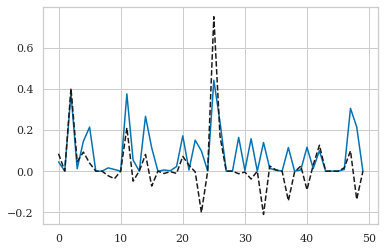

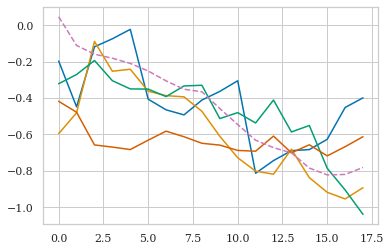

In [39]:
plt.plot(gpkwts/(gpkwts**2).sum()**0.5)
plt.plot(wts/(wts**2).sum()**0.5, 'k--')
plt.show()
wtspos = np.where(wts > 0.1)[0]
plt.plot(gp.X_train_[wtspos].T)
plt.plot(yy[:T0], '--')

In [16]:
kernel = kernels.RBF
kernel = kernels.Matern

    
gpfits = {}
gpfitspca99 = {}
gpfitspca95 = {}
# gpfitspca90, gpfitspca70 = {}, {}

for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds

 
    def getgppca(ddict, ncomp):
            if ncomp is not None:
                if ncomp == xx.shape[0] or ncomp == T0: ncomp -=1
                pclpre = PCA(ncomp).fit(xx[:, :T0])
                xxpre = pclpre.inverse_transform(pclpre.transform(xx[:, :T0]))
                yypre = pclpre.inverse_transform(pclpre.transform(yy[:T0].reshape(1, -1))).flatten()
#                 pclpost = PCA(ncomp).fit(xx[:, T0:])
#                 xxpost = pclpost.inverse_transform(pclpost.transform(xx[:, T0:]))
#                 yypost = pclpost.inverse_transform(pclpost.transform(yy[T0:].reshape(1, -1))).flatten()
                xxpost = xx[:, T0:]
                yypost = yy[T0:]
                alpha = (xx[:, :T0] - xxpre).std(axis=1)
            else:
                xxpre, xxpost = xx[:, :T0].copy(), xx[:, T0:].copy()
                yypre, yypost = yy[:T0].copy(), yy[T0:].copy()
                alpha = xxpre.std(axis=1)/100.

        #     gp = GPR(kernels.RBF(1, [1e-1, 100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            gp = GPR(kernels.Matern(xxpre.std(axis=0), [xxpre.std()/100, xxpre.std()*100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            yp = np.squeeze(gp.predict(yypre.reshape(1, -1)))
            kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
            wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
            yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
            yp = yp*stds + means
            ypred = (np.dot(wts, xx))*stds + means
#             ypred = np.dot(wts, xxc)
            #
            ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
            ysample = ysample.T*stds[T0:]
            err = np.append(np.zeros(T0), ysample.std(axis=0))
#             if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre, pcapost=pclpost, wts=wts, kwts=kwts)
            if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre,  wts=wts, kwts=kwts)
            else: ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, wts=wts, kwts=kwts)
            
    getgppca(gpfits, None)    
#           
    ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.99)
    getgppca(gpfitspca99, ncomp)
    
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95) == ncomp:
        gpfitspca95[ss] = gpfitspca99[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95)
        getgppca(gpfitspca95, ncomp)
        
#     if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90) == ncomp:
#         gpfitspca90[ss] = gpfitspca95[ss]
#     else:
#         ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90)
#         getgppca(gpfitspca90, ncomp)
    
#     if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70) == ncomp:
#         gpfitspca70[ss] = gpfitspca90[ss]
#     else:
#         ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70)
#         getgppca(gpfitspca70, ncomp)
 

    


In [14]:

        
# gpfitspcawts99  =   {}


# for ii, ss in enumerate(np.arange(N)):
#     xxc = np.concatenate([X[:ii], X[ii+1:]])
#     yyc = X[ii]
#     means = xxc.mean(axis=0)
#     stds = xxc.std(axis=0)*1# + 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds
    
#     #####
#     X1 = xx[:, :T0]
#     Y1 = yy[:T0]
# #     X2 = xx[:, T0:]
# #     Y2 = yy[T0:]
#     X2 = xx[:, :]
#     Y2 = yy[:]
#     #
#     nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
#     if nc1 <=1 : nc1 +=1 
#     if nc2 <=1 : nc2 +=1 
#     p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
#     XX1, XX2 = p1.transform(X1), p2.transform(X2)
#     YY1 = p1.transform(Y1.reshape(1,-1))
#     stds1, stds2 = XX1.std(axis=0), XX2.std(axis=0)
#     XX1 /= stds1
#     YY1 /= stds1
#     XX2 /= stds2
    
#     alpha = 0.01
#     gp = GPR(kernel(XX1.std(axis=0), length_scale_bounds=[0.01, 10.]), n_restarts_optimizer=20, alpha=alpha).fit(XX1, XX2)
#     yp = np.squeeze(gp.predict(YY1.reshape(1, -1)))
#     kwts = gp.kernel_(gp.X_train_, YY1.reshape(1, -1)).flatten()
#     wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
# #     yp = np.concatenate([p1.inverse_transform(stds1*np.dot(wts, gp.X_train_)), p2.inverse_transform(stds2*yp)])
#     yp = p2.inverse_transform(stds2*yp)
#     yp *= stds
#     yp += means

# #     ysample = np.squeeze(gp.sample_y(YY1.reshape(1, -1), 100))        
# #     ysample = ysample.T*stds[T0:]
# #     err = np.append(np.zeros(T0), ysample.std(axis=0))
#     gpfitspcawts99[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, nc1=nc1, nc2=nc2, pca1=p1, pca2=p2)


# gpfitspcawts99  =   {}

# for ii, ss in enumerate(np.arange(N)):
#     xxc = np.concatenate([X[:ii], X[ii+1:]])
#     yyc = X[ii]
#     means = xxc.mean(axis=0)
#     stds = xxc.std(axis=0)*1# + 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds

    
#     #####
#     X1 = xx[:, :T0]
#     X2 = xx[:, T0:]
#     Y1 = yy[:T0]
#     Y2 = yy[T0:]
#     #
#     nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
#     if nc1 <=1 : nc1 +=1 
#     if nc2 <=1 : nc2 +=1 
#     p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
#     XX1, XX2 = p1.transform(X1), p2.transform(X2)
#     YY1 = p1.transform(Y1.reshape(1,-1))
#     stds1, stds2 = XX1.std(axis=0), XX2.std(axis=0)
#     XX1 /= stds1
#     YY1 /= stds1
#     XX2 /= stds2
    
#     alpha = 1e-10
#     gp = GPR(kernels.RBF(XX1.std(axis=0), length_scale_bounds=[0.01, 10.]),
#              n_restarts_optimizer=100, alpha=alpha).fit(XX1, XX2)
# #     gp = GPR(kernels.RBF(XX1.std(axis=0), length_scale_bounds=[XX1.std(axis=0).min()/3., XX1.std(axis=0).max()*3.]),
# #              n_restarts_optimizer=100, alpha=alpha).fit(XX1, XX2)
# #     gp = GPR(kernels.RBF(0.1, length_scale_bounds=[1e-2, 10]), n_restarts_optimizer=20, alpha=alpha).fit(XX1, XX2)
#     yp2 = np.squeeze(gp.predict(YY1.reshape(1, -1)))
#     kwts = gp.kernel_(gp.X_train_, YY1.reshape(1, -1)).flatten()
#     wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
#     yp1 = np.dot(wts, gp.X_train_)
# #     yp1 = YY1.flatten()
#     yp = np.concatenate([p1.inverse_transform(yp1*stds1), p2.inverse_transform(yp2*stds2)])
# #     yp = p2.inverse_transform(yp2*stds2)    
#     yp *= stds
#     yp += means

#     gpfitspcawts99[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, nc1=nc1, nc2=nc2, pca1=p1, pca2=p2)


    

# xplot = np.arange(X.shape[1])
# titles = ['SCM', 'KDE', 'GP',  'SCM - Resdiual', 'KDE - Residual',  'GP - Residual']
# for j, fits in enumerate([gpfitspcawts99]):
#     tmp = []
#     print(j, j//2 + j%2)
#     axis = plt.gca()
#     for ii in range(X.shape[0]): 
#         tmp.append(fits[ii].treated - fits[ii].pred)
# #         if i  : tmp[-1][:T0] *= 0
# #         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
#         axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
#     tmp = np.array(tmp)
#     mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
#     axis.plot(xplot, tmp[itreated], 'k', lw=2)
#     axis.plot(xplot, mmean, 'C1', lw=2)
#     axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
#     axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
# #     axis.set_ylim(-100, 100)
#     axis.axhline(0, color='r', ls="--")


In [17]:
   
gpfitsres = {}
gpfitspca99res, gpfitspca95res  = {}, {}
# gpfitspca90res, gpfitspca70res =  {}, {}

for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*1
    stds = xxc.std(axis=0)*1 #+ 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    mmx, mmy = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
    xx -= mmx
    yy -= mmy

    ####
#
    def getgppcares(ddict, ncomp):
            if ncomp is not None:
                if ncomp >= xx.shape[0] or ncomp >= xx.shape[1]: ncc = ncomp - 1
                else: ncc = ncomp
                pclpre = PCA(ncc).fit(xx[:, :T0])
                xxpre = pclpre.inverse_transform(pclpre.transform(xx[:, :T0]))
                yypre = pclpre.inverse_transform(pclpre.transform(yy[:T0].reshape(1, -1))).flatten()
#                 pclpost = PCA(ncc).fit(xx[:, T0:])
#                 xxpost = pclpost.inverse_transform(pclpost.transform(xx[:, T0:]))
#                 yypost = pclpost.inverse_transform(pclpost.transform(yy[T0:].reshape(1, -1))).flatten()
                xxpost = xx[:, T0:]
                yypost = yy[T0:]
                alpha = (xx[:, :T0] - xxpre).std(axis=1)
            else:
                xxpre, xxpost = xx[:, :T0].copy(), xx[:, T0:].copy()
                yypre, yypost = yy[:T0].copy(), yy[T0:].copy()
                alpha = xxpre.std(axis=1)/100.
            #     gp = GPR(kernels.RBF(1, [1e-1, 100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            gp = GPR(kernels.Matern(xxpre.std(axis=0), [xxpre.std()/100, xxpre.std()*100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            yp = np.squeeze(gp.predict(yypre.reshape(1, -1)))
            kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
            wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
            yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
            yp = (yp + mmy)*stds + means
            ypred = (np.dot(wts, xx) + mmy)*stds + means
            #
            ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
            ysample = ysample.T*stds[T0:]
            err = np.append(np.zeros(T0), ysample.std(axis=0))
            
#             if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre, pcapost=pclpost, wts=wts, kwts=kwts)
            if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre,  wts=wts, kwts=kwts)
            else: ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, wts=wts, kwts=kwts)
            
            
    getgppcares(gpfitsres, None)
    
    ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.99)
    getgppcares(gpfitspca99res, ncomp)
    
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95) == ncomp:
        gpfitspca95res[ss] = gpfitspca99res[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95)
        getgppcares(gpfitspca95res, ncomp)
        
#     if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90) == ncomp:
#         gpfitspca90res[ss] = gpfitspca95res[ss]
#     else:
#         ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90)
#         getgppcares(gpfitspca90res, ncomp)
    
#     if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70) == ncomp:
#         gpfitspca70res[ss] = gpfitspca90res[ss]
#     else:
#         ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70)
#         getgppcares(gpfitspca70res, ncomp)
        
        

In [ ]:


gpfitspcawts99res = {}

for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*1
    stds = xxc.std(axis=0)*1 #+ 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    mmx, mmy = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
    xx -= mmx
    yy -= mmy
    #####
    X1 = xx[:, :T0]
    Y1 = yy[:T0]
#     X2 = xx[:, T0:]
#     Y2 = yy[T0:]
    X2 = xx[:, :]
    Y2 = yy[:]
    
    #
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    stds1, stds2 = XX1.std(axis=0), XX2.std(axis=0)
    XX1 /= stds1
    YY1 /= stds1
    XX2 /= stds2
    
    alpha = 0.001
    gp = GPR(kernel(XX1.std(axis=0)/3., length_scale_bounds=[0.01, 10]), n_restarts_optimizer=20, alpha=alpha).fit(XX1, XX2)
    yp = np.squeeze(gp.predict(YY1.reshape(1, -1)))
    kwts = gp.kernel_(gp.X_train_, YY1.reshape(1, -1)).flatten()
    wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
    yp = p2.inverse_transform(yp*stds2)
#     yp = np.concatenate([p1.inverse_transform(np.dot(wts, gp.X_train_)), p2.inverse_transform(yp)])
#     yp = np.concatenate([Y1, p2.inverse_transform(yp)])
    yp = (yp + mmy)*stds + means
    gpfitspcawts99res[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, pca1=p1, pca2=p2, wts=wts, kwts=kwts)
     
    


gp 19.622278948301187
gp pca99 21.577554769683644
gp pca 95 19.584728646138334
gpres 18.554316608025644
gp res pca99 17.673974103182392
gp res 95 19.324816478005044


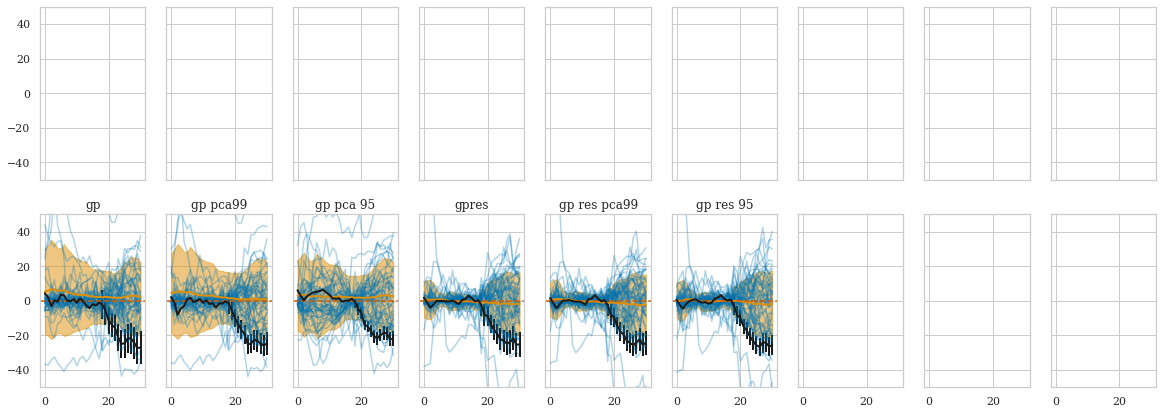

In [18]:
fig, ax = plt.subplots(2, 9, figsize=(20, 7), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

# titles = ['scmfits', 'scmfitsres',   'pcafits95', 'pcafits99', 'pcafits99reg', 'pcafitsyj99', 'kdefitspca99', 'kdefitsres', 'kdefitsrespca99']
# # for j, fits in enumerate([scmfits, scmfitsres,  pcafits95, pcafits99, pcafits99reg, pcafitsyj99, kdefitspca99, kdefitsres, kdefitsrespca99]):
# for j, fits in enumerate([scmfits, scmfitsres]):
#     print(titles[j])
#     tmp = []
#     axis = ax[0].flatten()[j]
#     for ii in range(X.shape[0]): 
#         tmp.append(fits[ii].treated - fits[ii].pred)
#         axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
#     tmp = np.array(tmp)
#     mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
#     print(titles[j], sstd[-1])
#     axis.plot(xplot, tmp[itreated], 'k', lw=2)
#     axis.plot(xplot, mmean, 'C1', lw=2)
#     axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
#     axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
#     axis.axhline(0, color='r', ls="--")

    
titles = ['gp', 'gp pca99', 'gp pca 95', 'gpres', 'gp res pca99', 'gp res 95']
for j, fits in enumerate([gpfits, gpfitspca99, gpfitspca95, gpfitsres, gpfitspca99res, gpfitspca95res]):
    tmp = []
    axis = ax[1].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
#     axis.plot(xplot, tmp[itreated], 'k', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color= 'k', lw=2)
    except:     axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
    axis.set_ylim(-50, 50)
    axis.axhline(0, color='r', ls="--")


scmfits
scmfits 23.5314364143329
scmfitsres
scmfitsres 23.925249725482125
kdefitspca99
kdefitspca99 28.069277252808263
kdefitsres
kdefitsres 26.43310204458089
kdefitsrespca99
kdefitsrespca99 28.47106319756175
gp 27.680138048682846
gp pca99 27.254107228116133
gp pcawts99 31.493661137394856
gpres 28.048493082221228
gp res pca99 28.34914823672007
gpfitspcawts99res 29.37618169954311


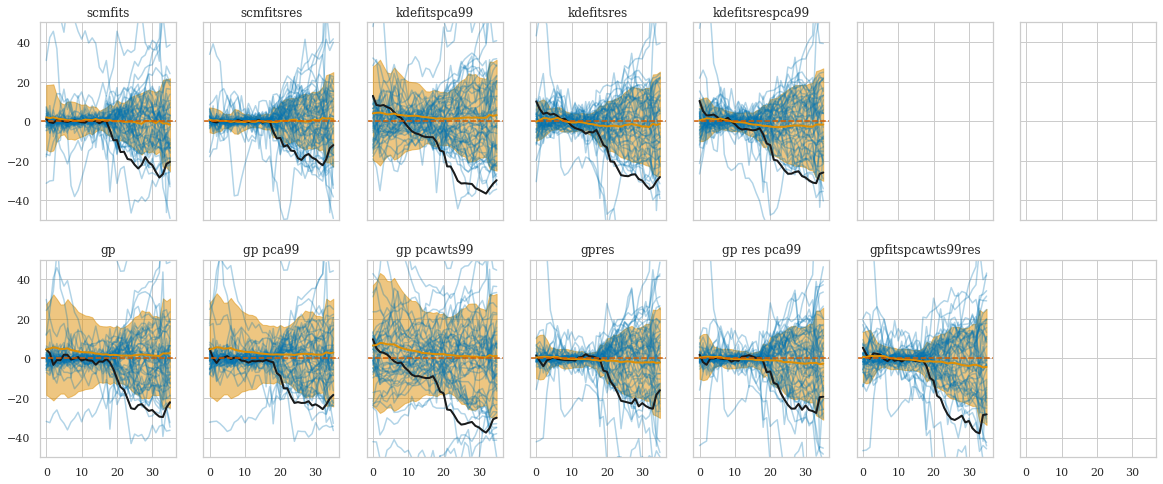

In [172]:
fig, ax = plt.subplots(2, 7, figsize=(20, 8), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = ['scmfits', 'scmfitsres',   'kdefitspca99', 'kdefitsres', 'kdefitsrespca99']
for j, fits in enumerate([scmfits, scmfitsres,  kdefitspca99, kdefitsres, kdefitsrespca99]):
    print(titles[j])
    tmp = []
    axis = ax[0].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
    axis.set_ylim(-50, 50)
    axis.axhline(0, color='r', ls="--")

    
titles = ['gp', 'gp pca99', 'gp pcawts99', 'gpres', 'gp res pca99', 'gpfitspcawts99res']
for j, fits in enumerate([gpfits, gpfitspca99, gpfitspcawts99, gpfitsres, gpfitspca99res, gpfitspcawts99res]):
    tmp = []
    axis = ax[1].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
    axis.set_ylim(-50, 50)
    axis.axhline(0, color='r', ls="--")


0 0
1 1
2 1
3 2
4 2
5 3


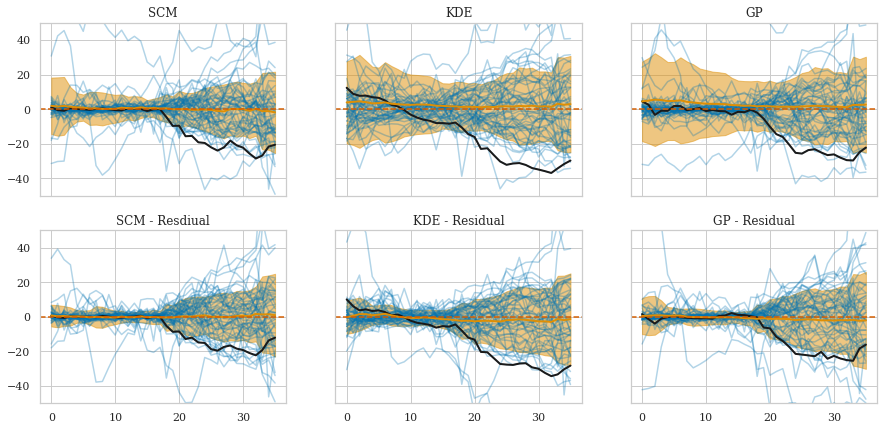

In [173]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])
    
# titles = ['gp', 'gp pca99', 'gp pcawts99', 'gpres', 'gp res pca99', 'gp res pcawts99']
# for j, fits in enumerate([gpfits, gpfitspca99, gpfitspcawts99, gpfitsres, gpfitspca99res, gpfitspcawts99res]):
titles = ['SCM', 'KDE', 'GP',  'SCM - Resdiual', 'KDE - Residual',  'GP - Residual']
for j, fits in enumerate([scmfits,  kdefits,  gpfits, scmfitsres, kdefitsres, gpfitsres]):
# titles = ['SCM',  'GP', 'GP - Residual']
# for j, fits in enumerate([scmfits,  gpfits]):
    tmp = []
    print(j, j//2 + j%2)
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
#         if i  : tmp[-1][:T0] *= 0
#         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
    axis.set_ylim(-50, 50)
    axis.axhline(0, color='r', ls="--")

# titles = ['SCM',  'GP', 'GP - Residual']
# for j, fits in enumerate([scmfits,  gpfits]):
#     tmp = []
#     axis = ax[1].flatten()[j]
#     for ii in range(X.shape[0]): 
#         tmp.append(fits[ii].treated - fits[ii].pred)
# #         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
#         axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
#     tmp = np.array(tmp)
#     mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
#     axis.plot(xplot, tmp[itreated], 'k', lw=2)
#     axis.plot(xplot, mmean, 'C1', lw=2)
#     axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
#     axis.set_title(titles[j])
# #     axis.set_ylim(-2, 2)
#     axis.set_ylim(-100, 100)
#     axis.axhline(0, color='r', ls="--")


# plot

NameError: name 'kdefitsres' is not defined

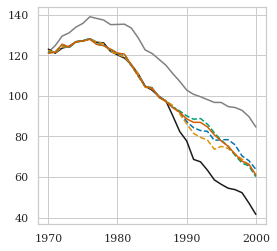

In [335]:
plt.figure(figsize = (9, 4))
plt.subplot(121)
plt.plot(years, scmfitsres[itreated].controls.mean(axis=0), 'gray',label='Mean')
plt.plot(years, scmfitsres[itreated].treated, 'k-', label='Data')
plt.plot(years, scmfits[itreated].pred, '--', label='SCM')
plt.plot(years, scmfitsres[itreated].pred, '--', label='SCM Res')
plt.plot(years, pcafits99[itreated].pred, '--', label='PCR')
plt.plot(years, pcafitsyj99[itreated].pred, label='Prob PCR')
plt.plot(years, kdefitsres[itreated].pred, label='KDE')
plt.errorbar(years, gpfitsres[itreated].pred, gpfitsres[itreated].err, label='GPR')
plt.legend()

plt.subplot(122)
plt.plot(scmfitsres[itreated].treated, 'k-', label='Data')
plt.plot(pcafits95[itreated].pred, '--', label='PCR')
plt.plot(pcafitsyj95[itreated].pred, label='Prob PCR')
plt.plot(pcafits99[itreated].pred, '--', label='PCR')
plt.plot(pcafitsyj99[itreated].pred, label='Prob PCR')
plt.legend()

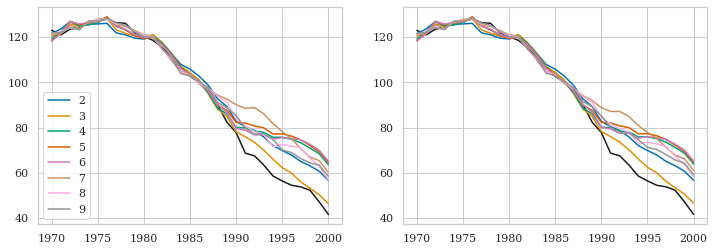

In [203]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(years, treated, 'k')
for ncomp in range(2, 10):
    ax[0].plot(years, pcapreds[ncomp].pred, label=ncomp)
ax[0].legend()

ax[1].plot(years, treated, 'k')
for ncomp in range(2, 10):
    ax[1].plot(years, pcapredsyj[ncomp].pred)


0 0
1 1
2 1
3 2
4 2
5 3


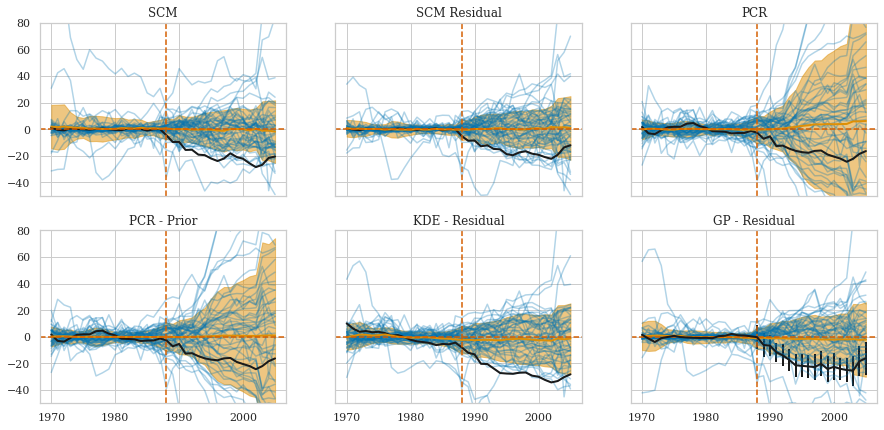

In [99]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)

xplot = years #np.arange(X.shape[1])
    
titles = ['SCM', 'SCM Residual', 'PCR',  'PCR - Prior', 'KDE - Residual',  'GP - Residual']
for j, fits in enumerate([scmfits,  scmfitsres, pcafits95,  pcafitsyj95, kdefitsres, gpfitsres]):
    tmp = []
    print(j, j//2 + j%2)
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color= 'k', lw=2)
    except:     axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-50, 80)
    axis.axhline(0, color='r', ls="--")
    axis.axvline(years[T0], color='r', ls="--")
# plt.savefig('../new_figs/cal_all95.png')

NameError: name 'kdefitsres' is not defined

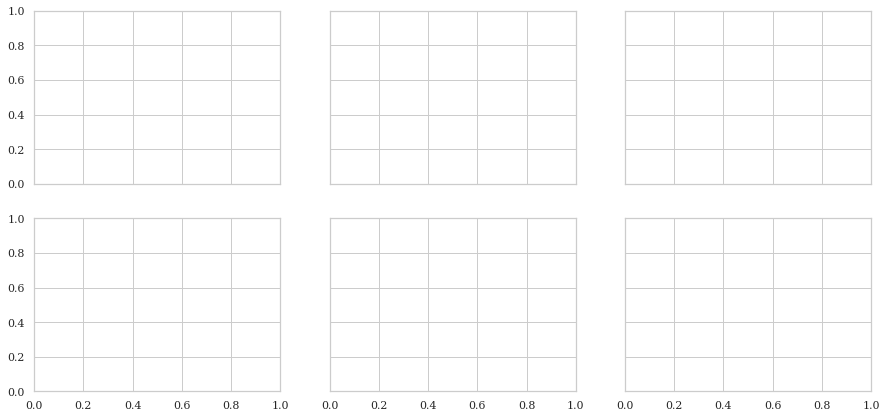

In [267]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)

xplot = years #np.arange(X.shape[1])
    
titles = ['SCM', 'SCM Residual', 'PCR',  'PCR - Prior', 'KDE - Residual',  'GP - Residual']
for j, fits in enumerate([scmfits,  scmfitsres, pcafits99,  pcafitsyj99, kdefitsres, gpfitsres]):
    tmp = []
    print(j, j//2 + j%2)
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color= 'k', lw=2)
    except:     axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-50, 80)
    axis.axhline(0, color='r', ls="--")
    axis.axvline(years[T0], color='r', ls="--")
# plt.savefig('../new_figs/cal_all99.png')

# Save

NameError: name 'pcafits99regnoisepca' is not defined

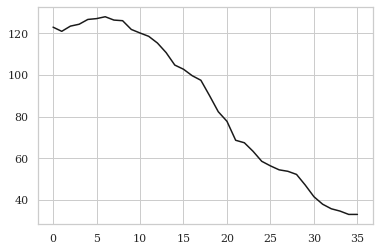

In [266]:
ii = itreated 

plt.plot(xplot, pcafits95regnoise[itreated].treated, 'k')

# plt.errorbar(xplot, pcafits95regnoise[itreated].pred, pcafits95regnoise[itreated].err)
# plt.errorbar(xplot+0.2, pcafits95regnoisepca[itreated].pred, pcafits95regnoisepca[itreated].err)
# plt.errorbar(xplot+0.4, pcafits95reg[itreated].pred, pcafits95reg[itreated].err)

# plt.errorbar(xplot, pcafitsyj95noise[itreated].pred, pcafitsyj95noise[itreated].err)
# plt.errorbar(xplot+0.3, pcafitsyj95noisepca[itreated].pred, pcafitsyj95noisepca[itreated].err)
# plt.errorbar(xplot+0.5, pcafitsyj95[itreated].pred, pcafitsyj95[itreated].err)

# plt.errorbar(xplot, pcafits99regnoise[itreated].pred, pcafits99regnoise[itreated].err)
plt.errorbar(xplot+0.2, pcafits99regnoisepca[itreated].pred, pcafits99regnoisepca[itreated].err)
# plt.errorbar(xplot+0.4, pcafits99reg[itreated].pred, pcafits99reg[itreated].err)

# plt.errorbar(xplot, pcafitsyj99noise[itreated].pred, pcafitsyj99noise[itreated].err)
plt.errorbar(xplot+0.3, pcafitsyj99noisepca[itreated].pred, pcafitsyj99noisepca[itreated].err)
# plt.errorbar(xplot+0.5, pcafitsyj99[itreated].pred, pcafitsyj99[itreated].err)


In [21]:
ofolder = '../tmpdata/prop99_2000/'

# # titles = ['scmfits','scmfitsres']
# # for j, fits in enumerate([scmfits,  scmfitsres]):
# #     tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(X.shape[0])])
# #     np.save(ofolder + '/%s'%titles[j], tosave)
    
titles = 'glfits'
titles = titles.split(', ')
for j, fits in enumerate([glfits]):
    try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
    except: 
        print(titles[j])
        tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
    np.save(ofolder + '/%s'%titles[j], tosave)

# titles = 'svdfits99, pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise'
# titles = titles.split(', ')
# for j, fits in enumerate([svdfits99, pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save(ofolder + '/%s'%titles[j], tosave)

# titles = 'pcafits95, pcafits99'
# titles = titles.split(', ')
# for j, fits in enumerate([pcafits95, pcafits99]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save(ofolder + '/%s'%titles[j], tosave)
        
    
# # # titles = 'svdfits99, pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise'
# # # titles = titles.split(', ')
# # titles = 'pcafits95regnoisepca, pcafits99regnoisepca, pcafitsyj95noisepca, pcafitsyj99noisepca'
# # titles = titles.split(', ')
# # for j, fits in enumerate([pcafits95regnoisepca, pcafits99regnoisepca, pcafitsyj95noisepca, pcafitsyj99noisepca]):
# #     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
# #     except: 
# #         print(titles[j])
# #         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
# #     np.save(ofolder + '/%s'%titles[j], tosave)

# # titles = 'kdefits, kdefitspca99, kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99'
# # titles = titles.split(', ')
# # for j, fits in enumerate([kdefits, kdefitspca99, kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
# #     tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(X.shape[0])])
# #     np.save(ofolder + '/%s'%titles[j], tosave)
    
# # titles = 'gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspcawts99, gpfitspcawts99res, gpfitspcawts99res'
# # titles = titles.split(', ')
# # for j, fits in enumerate([gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspcawts99, gpfitspcawts99res, gpfitspcawts99res]):
# #     tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
# #     np.save(ofolder + '/%s'%titles[j], tosave)

# # titles = 'gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspca95, gpfitspca95res'
# # titles = titles.split(', ')
# # for j, fits in enumerate([gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspca95, gpfitspca95res]):
# #     tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
# #     np.save(ofolder + '/%s'%titles[j], tosave)

# titles = 'pcapreds, pcapredsreg, pcapredsyj, svdpreds, pcapredsregnoise, pcapredsyjnoise'
# titles = titles.split(', ')
# # for j, fits in enumerate([pcapreds, pcapredsreg, pcapredsyj, svdpreds, pcapredsregnoise, pcapredsyjnoise, pcapredsregnoisepca, pcapredsyjnoisepca]):
# for j, fits in enumerate([pcapreds, pcapredsreg, pcapredsyj, svdpreds, pcapredsregnoise, pcapredsyjnoise]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(1, 11)])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save(ofolder + '/%s'%titles[j], tosave)


In [20]:
# pcafits95regnoise[1].pred.size, 
glfits[1].pred.size
# pcapredsregnoisepca[1].pred.size

31

NameError: name 'pcafits' is not defined

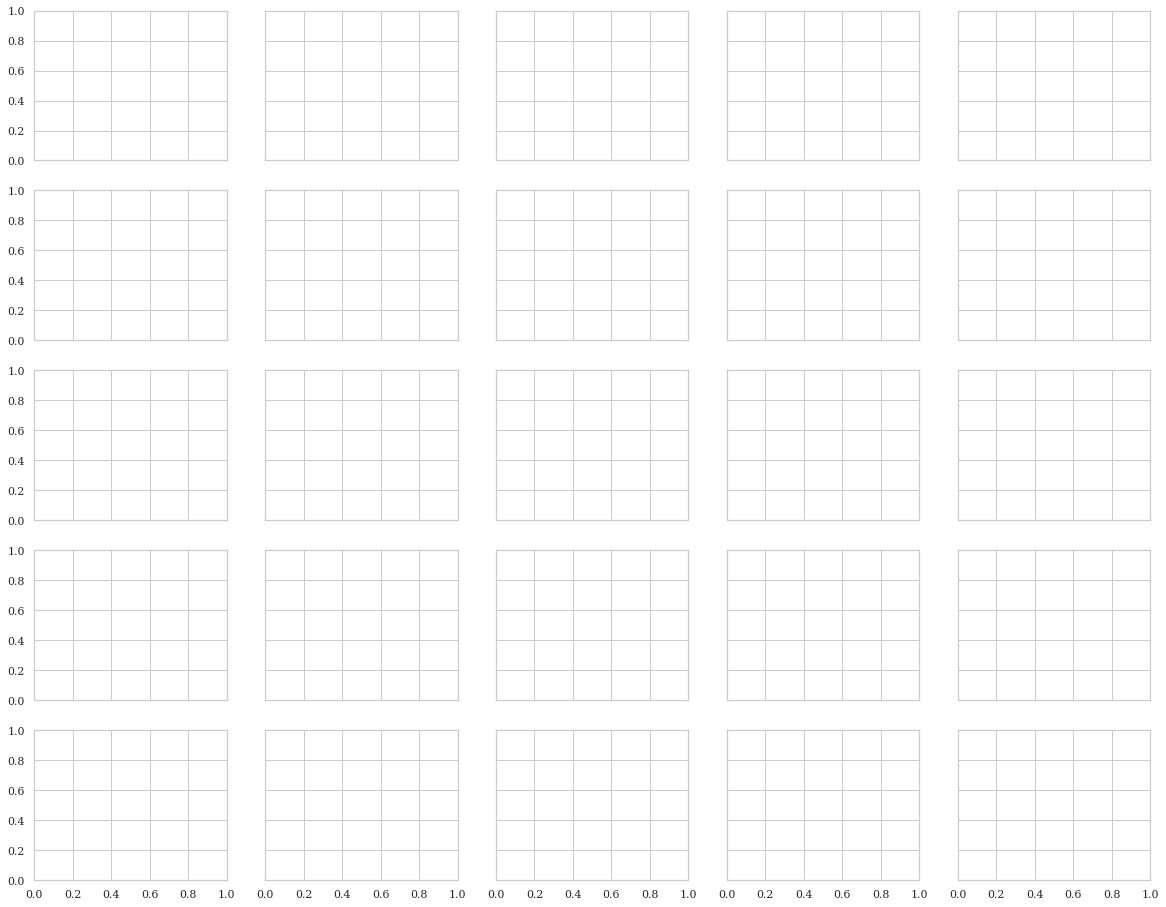

In [102]:


nrow =  5
ncol = 5
irs = np.sort(np.random.permutation(np.arange(N))[:nrow*ncol-1])
fig, axar = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3.2),
                         sharex=True, sharey=True)
ax = axar.flatten()

for jj, ss in enumerate(irs):
    ii = jj + 1
    xx = pcafits[ss].controls
    means, stds = xx.mean(axis=0), xx.std(axis=0)
    yy = pcafits[ss].treated
    
    ax[ii].plot(years, means, 'k--')
    ax[ii].fill_between(years, means-stds, means+stds, color='gray', alpha=0.2)
    ax[ii].plot(years, yy, 'k', lw=2)
    
    ax[ii].plot(years, scmfits[ss].pred, 'k:')
    ax[ii].plot(years, pcafits[ss].pred, 'C0-')
    ax[ii].plot(years, pcafits3[ss].pred, 'C0--')
    ax[ii].plot(years, pcafitsyj[ss].pred, 'C1-')
#     ax[ii].plot(years, pcafitsyj3[ss].pred, 'C1--')
    
#     ax[ii].plot(years, svdfitsfits[ss].pred, 'C3-')
#     ax[ii].plot(years, svdfitsfitsc[ss].pred, 'C3--')
#     ax[ii].plot(years, svdfitsfitsc3[ss].pred, 'C3:', lw=2)
    
    ax[ii].plot(years, kdefits[ss].pred, 'C4-')
    ax[ii].plot(years, kdefitspca99[ss].pred, 'C4--')
    ax[ii].plot(years, kdefitsres[ss].pred, 'C4:', lw=2)

    ax[ii].plot(years, gpfits[ss].pred, 'C7-')
    ax[ii].plot(years, gpfitspca99[ss].pred, 'C7--')
    ax[ii].plot(years, gpfitsres[ss].pred, 'C7:', lw=2)
    ax[ii].set_title(ss, fontsize=12)
    
ss = itreated
ii=0
xx = pcafits[ss].controls
means, stds = xx.mean(axis=0), xx.std(axis=0)
yy = pcafits[ss].treated
yp = synth.fit(xx, yy, T0)[0]

ax[ii].plot(years, means, 'k--')
ax[ii].fill_between(years, means-stds, means+stds, color='gray', alpha=0.2)
ax[ii].plot(years, yy, 'k', label='Data', lw=2)

ax[ii].plot(years, scmfits[ss].pred, 'k:', label='SCM')
ax[ii].plot(years, pcafits[ss].pred, 'C0-', label='PCA')
ax[ii].plot(years, pcafits3[ss].pred, 'C0--', label='PCA3')
ax[ii].plot(years, pcafitsyj[ss].pred, 'C1-', label='PCA-YJ')
# ax[ii].plot(years, pcafitsyj3[ss].pred, 'C1--', label='PCA-YJ3')
# ax[ii].plot(years, svdfitsfits[ss].pred, 'C3-', label='SVD')
# ax[ii].plot(years, svdfitsfitsc[ss].pred, 'C3--', label='SVD-C')
# ax[ii].plot(years, svdfitsfitsc[ss].pred, 'C3:', label='SVD-C3')
ax[ii].plot(years, kdefits[ss].pred, 'C4-', label='KDE')
ax[ii].plot(years, kdefitspca99[ss].pred, 'C4--', label='KDE-PCA')
ax[ii].plot(years, kdefitsres[ss].pred, 'C4:', label='KDE-PCA3')
ax[ii].plot(years, gpfits[ss].pred, 'C7-', label='GP')
ax[ii].plot(years, gpfitspca99[ss].pred, 'C7--', label='GP-PCA')
ax[ii].plot(years, gpfitsres[ss].pred, 'C7:', label='GP-PCA3', lw=2)
ax[ii].set_title(ss, fontsize=12)
ax[ii].legend(ncol=8, fontsize=13, loc=3, bbox_to_anchor=(0, 1.05))

for axis in ax:
#     axis.set_xlim(1969, 2005)
    axis.set_ylim(-50, 200)
#     axis.axvline(1988, color='c', ls='--')
    ax[0].legend(ncol=6, bbox_to_anchor=(4.5, 1.3), fontsize=12)
    
plt.show()

In [ ]:
# for ss in [itreated]:
#     w1, w2 = kdefits[ss].wts.flatten(), scmfits[ss].wts.flatten()
#     w1 /= w1.sum()
#     w2 /= w2.sum()
#     w1[w1<0.01] = 0
#     w2[w2<0.01] = 0
#     print(ss, np.corrcoef(w1, w2)[0, 1])
    
#     fig, ax = plt.subplots(1,1, figsize=(8, 5))
#     ax = [ax]
#     ii=0
#     ax[ii].plot(years, scmfits[ss].treated, 'k',lw=2, label='Data')

#     ax[ii].plot(years, scmfits[ss].pred, 'k:', label='SCM')

#     ax[ii].plot(years, svdfitsfits[ss].pred, 'C0-', label='SVD')
#     ax[ii].plot(years, svdfitsfitsc[ss].pred, 'C0--', lw=2, label='SVD-C')
#     ax[ii].plot(years, svdfitsfitsc3[ss].pred, 'C0:', lw=2, label='SVD-C3')

#     ax[ii].plot(years, kdefits[ss].pred, 'C1-', label='KDE')
#     ax[ii].plot(years, kdefitspca[ss].pred, 'C1--', label='KDE-PCA')
#     ax[ii].plot(years, kdefitspca3[ss].pred, 'C1:', label='KDE-PCA3')
    

#     ax[ii].plot(years, pcafits[ss].pred, 'C2', label='PCA')
#     ax[ii].plot(years, pcafits3[ss].pred, 'C2--', label='PCA-3')
#     ax[ii].plot(years, pcafitsyj[ss].pred, 'C4', label='PCA-YJ')
#     ax[ii].plot(years, pcafitsyj3[ss].pred, 'C4--', label='PCA-YJ-3')
    
#     ax[ii].errorbar(years, gpfits[ss].pred, gpfits[ss].err, color='C7', label='GP', elinewidth=0.5)
    
#     ax[ii].errorbar(years+0.25, gpfitspca[ss].pred, gpfitspca[ss].err, color='C9', ls="-", lw=1, elinewidth=0.5, label='GP-PCA')
#     ax[ii].errorbar(years-0.25, gpfitspca3[ss].pred, gpfitspca3[ss].err, color='C9', ls="--",  lw=2, elinewidth=0.5, label='GP-PCA3')

# plt.legend(loc=2, bbox_to_anchor=(1, 1))
# plt.axvline(T0, color='k', ls="--")
# # plt.xlim(1970, 2005)
# # plt.ylim(0, 200)

In [ ]:
diffscm  = np.zeros_like(controls)
diffsvd, diffsvdc, diffsvdc3  = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffkde, diffkdepca, diffkdepca3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffpca, diffpca3, diffpcayj, diffpcayj3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffgp, diffgppca, diffgppca3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)

for ii, ss in enumerate(np.arange(N-1)):
    if ii == itreated: continue
    xx = pcafits[ss].controls
    means, stds = xx.mean(axis=0), xx.std(axis=0)
    yy = pcafits[ss].treated

    diffscm[ii] = (yy-scmfits[ss].pred)

    diffpca[ii] = (yy-pcafits[ss].pred)
    diffpcayj[ii] = (yy-pcafitsyj[ss].pred)    
    diffpca3[ii] = (yy-pcafits3[ss].pred)
#     diffpcayj3[ii] = (yy-pcafitsyj3[ss].pred)
    
#     diffsvd[ii] = (yy-svdfitsfits[ss].pred)
#     diffsvdc[ii] = (yy-svdfitsfitsc[ss].pred)
#     diffsvdc3[ii] = (yy-svdfitsfitsc3[ss].pred)
    
    diffkde[ii] = (yy-kdefits[ss].pred)
    diffkdepca[ii] = (yy-kdefitspca[ss].pred)
    diffkdepca3[ii] = (yy-kdefitspca3[ss].pred)
    
    diffgp[ii] = (yy-gpfits[ss].pred)
    diffgppca[ii] = (yy-gpfitspca[ss].pred)
    diffgppca3[ii] = (yy-gpfitspca3[ss].pred)


In [ ]:



tmpy = pcafits[itreated].treated

fig, axar = plt.subplots(3, 5, figsize=(20, 14), sharex=True, sharey=True)
ax = axar.flatten()

dd = diffscm.copy()
ax[0].plot(years, dd.T, 'C0-', alpha=0.5)
ax[0].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
ax[0].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
ax[0].plot(years, tmpy - scmfits[itreated].pred, 'k-', alpha=1)
ax[0].set_title('SCM')
ax[0].set_ylabel("Data - Pred")


def tmpplot(ii, title, dd, ddca):
    ax[ii].plot(years, dd.T, 'C0-', alpha=0.5)
    ax[ii].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
    ax[ii].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
    ax[ii].plot(years, tmpy - ddca, 'k-', alpha=1)
    ax[ii].set_title(title)

ii, title, dd, ddca = 1, 'SVD', diffsvd.copy(), svdfitsfits[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 2, 'SVD-center', diffsvdc.copy(), svdfitsfitsc[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 3, 'SVD-center3', diffsvdc3.copy(), svdfitsfitsc3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 4, 'KDE', diffkde.copy(), kdefits[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 5, 'KDE-PCA', diffkdepca.copy(), kdefitspca[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 6, 'KDE-PCA3', diffkdepca3.copy(), kdefitspca3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 7, 'PCA', diffpca.copy(), pcafits[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 8, 'PCA-YJ', diffpcayj.copy(), pcafitsyj[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 9, 'PCA-3', diffpca3.copy(), pcafits3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 10, 'PCA-YJ3', diffpcayj3.copy(), pcafitsyj3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 11, 'GP', diffgp.copy(), gpfits[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 12, 'GP-PCA', diffgppca.copy(), gpfitspca[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 13, 'GP-PCA3', diffgppca3.copy(), gpfitspca3[itreated].pred
tmpplot(ii, title, dd, ddca)

for axis in ax:
#     axis.set_xlim(1969, 2005)
    axis.set_ylim(-100, 200)
    axis.axvline(T0, color='r', ls='--')


In [ ]:
plt.plot(kdefits[1].treated)
plt.plot(kdefits[1].pred)

In [ ]:
plt.plot(scmfits[3].treated)
plt.plot(scmfits[3].treated)


# Play

In [ ]:
pcl = pcalearn.PCAlearn(controls, 5, stdscale=False, normalization='center')
svl = SVDlearn(controls,  stdscale=False, normalization='center')

In [ ]:
svl.fit(treated, T0, 5)[0]/pcl.fit(treated, T0, regwt=None)[0]